In [1]:
%pip install pykrige
# %pip install ray
%pip install --upgrade earthaccess==0.5.3
# %pip install -U ipywidgets

  Using cached PyKrige-1.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
Using cached PyKrige-1.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (897 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached earthaccess-0.5.3-py3-none-any.whl.metadata (9.4 kB)
Using cached earthaccess-0.5.3-py3-none-any.whl (53 kB)
  Attempting uninstall: earthaccess
    Found existing installation: earthaccess 0.8.2
    Uninstalling earthaccess-0.8.2:
      Successfully uninstalled earthaccess-0.8.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from skimage.io import imsave, imread
from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
from pyproj import Proj, transform
from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
import time
from tqdm.notebook import trange, tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
# from scipy.interpolate import BivariateSpline, UnivariateSpline
from pykrige.ok import OrdinaryKriging
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon
import pygmt
import gc
import pytz
import pyproj
from pathlib import Path
# import ray

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Coefficients for calibration
calib_m = 0.93 #ORD, 0.79 OLS
calib_b = -0.11 #ORD, 0.73 OLS

# Functions

### Functions

In [27]:
# Functions to search and open Lansat scenes
'''
Functions to search, open, and analyze Landsat scenes.
Search_stac finds the Landsat scene based on user parameters, 
plot_search plots the locations of the landsat scenes from the search,
landsat_to_xarray takes one of those scenes and puts all bands into an xarray,
and create_masks produces cloud/ice/water masks for the scene. Subset_img 
subsets a landsat scene with coordinates that have been reprojected from lat/lon
and may be flipped in which is larger in the pair. Lsat_reproj can be used to reproject
while ensuring x and y pairs don't get flipped (common converting between espg 3031 and wgs84.
'''

def landsat_to_xarray(sceneid, bandNames=None):
    """
    Function to ingest landsat scenes from AWS s3 bucket with alternate href.
    Args:
        catalog: an intake STAC item collection
        bandNames: a list of the bands you want e.g. ['red', 'swir16']
    Returns:
        Xarray of scenes with dimensions time, band, y, x
    """

    # Import to xarray with cloud mask
    # nans are in locations where concat of multiple scenes has expanded the grid
    item = catalog[sceneid.id]

    bands = []
    band_names = []

    if bandNames is None:
        # Get band names
        for k in item.keys():
            M = getattr(item, k).metadata
            if 'eo:bands' in M:
                resol = M['eo:bands'][0]['gsd']
                if resol >= 30: # thermal bands are up sampled from 100 to 30
                    band_names.append(k)
    else:
        band_names = bandNames

    # Add qa band
    if 'qa_pixel' not in band_names:
        band_names.append('qa_pixel')
    
    band_names.append('VZA')
    band_names.append('qa_radsat')

    # Construct xarray for scene
    for band_name in band_names:
        asset = sceneid.assets[band_name]
        href = asset.extra_fields['alternate']['s3']['href']
        band = xr.open_dataset(href, engine='rasterio', chunks=dict(band=1, x=512, y=512))
        band['band'] = [band_name]
        bands.append(band)
    ls_scene = xr.concat(bands, dim='band')
    ls_scene.coords['id'] = sceneid.id
    ls_scene.coords['time'] = item.metadata['datetime'].strftime('%Y-%m-%dT%H:%M:%S')
    ls_scene = ls_scene['band_data']

    return ls_scene

##########################

def create_masks(ls_scene, cloud_mask=True, ice_mask=False, ocean_mask=False):
    """
    Create cloud, ice, and ocean masks. cloud is 1, ice is 2, ocean is 3, everything else is NaN.
    Args:
        ls_scene: xarray of one LS scenes output from landsat_to_xarray
        cloud_mask: bool to generate cloud mask, default True
        ice_mask: bool to generate ice mask, default False
        ocean_mask: bool to generate ocean mask, default False
    Returns:
        new xarray of LS scene with mask
    """
    
    cloud = []
    ocean = []
    ice = []

    qa = ls_scene.sel(band='qa_pixel').astype('uint16')

    n,c = np.unique(qa, return_counts=True)

    for j in range(len(n)):
        longform = f'{n[j]:016b}'
        if (longform[-7]=='0')|(longform[-3]=='1'): #bit 2 and 6 are for cirrus and clear sky
            cloud.append(n[j])
        if longform[-8:]=='11000000': #bit 6 and 7 give clear sky and water, lower bits need to be 0 
            ocean.append(n[j])
        if longform[-7:]=='1100000': #bit 5 and 6 give ice and clear sky 
            ice.append(n[j])

    if 0 in cloud:
        cloud.remove(0)
    if 1 in cloud:
        cloud.remove(1)

    # mask cloud, ice, and ocean
    if cloud_mask==True:
        # cloud is 2
        mask_c = xr.where(qa.isin(cloud), 1, np.nan)

    if ice_mask==True:
        mask_c = xr.where(qa.isin(ice), 2, mask_c)

    if ocean_mask==True:
        mask_c = xr.where(qa.isin(ocean), 3, mask_c)

    ls_scene.coords['mask'] = (('y', 'x'), mask_c.data)
        
    return ls_scene

##########################

def normalize(array):
    '''
    normalize a dask array so all value are between 0 and 1
    '''
    array_min = array.min(skipna=True)
    array_max = array.max(skipna=True)
    return (array - array_min) / (array_max - array_min)

##########################

def search_stac(url,bbox,timeRange,collection,gjson_outfile):
    # Search STAC API for Landsat images based on a bounding box, date and other metadata if desired
    api = pystac_client.Client.open(url)

    items = api.search(
                bbox = bbox,
                datetime = timeRange,
                # limit = 400,
                collections=collection
            ).item_collection()

    print(f'{len(items)} Landsat 8/9 items')

    # Write a json file that records our search output
    items.save_object(gjson_outfile)
    
    return items

##########################

def plot_search(gf,satellite,colnm):
    # Plot search AOI and frames on a map using Holoviz Libraries (more on these later)
    cols = gf.loc[:,('id',colnm[0],colnm[1],'geometry')]
    alpha = 1/gf.shape[0]**0.5 # transparency scales w number of images

    footprints = cols.hvplot(geo=True, line_color='k', hover_cols=[colnm[0],colnm[1]], alpha=alpha, title=satellite,tiles='ESRI')
    tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
    labels = gv.tile_sources.StamenLabels.options(level='annotation')
    tiles * footprints * labels
    
    return footprints

##########################

def subset_img(da,polarx,polary):
    '''
    ***Only works for square grid cropping along the orientation of the grid (not when cropping along lat/lon in a 3031 grid
    
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(ls_sub.shape)
    
    return ls_sub

##########################

# def lsat_reproj(old_cs,new_cs,lbox):
    
#     # Create a transform object to convert between Landsat coordinate systems (mostly for in and out of espg 3031)
#     inProj = Proj(init=old_cs)
#     outProj = Proj(init=new_cs)
    
#     ULX,LRY,LRX,ULY = lbox

#     if LRY>ULY:
#         [ULX,LRX], [ULY,LRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
#     else:
#         [ULX,LRX], [ULY,LRY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    
#     bbox = (ULX,LRY,LRX,ULY)
    
#     return bbox

def lsat_reproj(old_cs,new_cs,lbox):
    '''
    bbox comes out with the points out of order for making a polygon though pairs are correct. Order is 0,3,1,2 when done in normal projection. 
    Haven't tested for flipped grid.
    '''
    
    test_threshold = 0.5
    
    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    [lULX,lLRX], [lULY,lLRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    [cULX,cLRX], [cULY,cLRY] =  transform(outProj,inProj,[lULX,lLRX], [lULY,lLRY], always_xy=True)
    [lLLX,lURX], [lLLY,lURY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    [cLLX,cURX], [cLLY,cURY] =  transform(outProj,inProj,[lLLX,lURX], [lLLY,lURY], always_xy=True)

    if LRY>ULY:
        bbox = [(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY)]
        # polygon = Polygon([(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY),(lULX,lLLY)])
        print('lsat_reproj flipped orientation')
    else:
        bbox = [(lULX,lULY),(lLLX,lLLY),(lLRX,lLRY),(lURX,lURY)]
        print('lsat_reproj normal orientation')

    checkbox = np.array([cULX,cULY,cLRX,cLRY])
    if np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY])) > test_threshold:
        print(f"Round-trip transformation error 1 of {np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY]))}")
    checkbox = np.array([cLLX,cLLY,cURX,cURY])
    if np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY])) > test_threshold:
        print(f"Round-trip transformation error 2 of {np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY]))}")
    print (f'bbox={bbox}')
    print (f'lbox={lbox}')
    print (f'checkbox={checkbox}')
    
    return bbox,checkbox

##########################

def crosses_idl(coords):
    '''
    Determine if the set of coordinates crosses the International Dateline in a way that will mess up the creation of a polygon
    
    Variables:
    coords = list of lon, lat tuples
    
    Output:
    True or False
    '''
    
    for (lon1, lat1), (lon2, lat2) in zip(coords, coords[1:]):
        if abs(lon1 - lon2) >= 180:
            return True
    return False

In [5]:
# Atmospheric correction and production of SST
'''
Functions to find the matching MODIS water vapor image for atmospheric correction and production of SST.
Open_MODIS finds and downloads the closest MODIS water vapor image to a specific landsat image. Get_wv
aligns and subsets the modis image grid to landsat using MODISlookup and subsamples and extracts the data 
onto the Landsat grid using uniqueMODIS
'''

def open_MODIS(ls_scene,scene,modout_path):
    '''
    Search MOD/MDY07 atmospheric data and open water vapor for data collected closest in time to 
    Landsat scene.
    
    Input:
    ls_scene = xarray dataset with Landsat scene
    modout_path = directory path for MODIS data
    scene = STAC catalog item
    
    Output:
    mod07 = xarray dataset with MODIS (MOD/MDY07) water vapor 
    modfilenm = MODIS filename for image used in atm correction
    '''
    
    # Get date/time for Landsat image and search for corresponding MODIS imagery  
    # ls_time = ls_scene.time.values.item()

    # Get spatial extent of Landsat scene in lat/lon
    mbbox = (scene.metadata['bbox'][0], scene.metadata['bbox'][1], scene.metadata['bbox'][2], scene.metadata['bbox'][3]) #(west, south, east, north) 
    lsatpoly = Polygon([(mbbox[0],mbbox[1]),(mbbox[0],mbbox[3]),(mbbox[2],mbbox[3]),(mbbox[2],mbbox[1]),(mbbox[0],mbbox[1])]) # ensure full lineup between landsat and modis

    # start_dt = ls_time[0:10]
    # calc_dt = datetime.strptime(start_dt, '%Y-%m-%d')
    # end_dt = (calc_dt + timedelta(days=1)).strftime('%Y-%m-%d')
    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')

    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    results = earthaccess.search_data(
        short_name='MOD07_L2',
        bounding_box=mbbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    results2 = earthaccess.search_data(
        short_name='MYD07_L2',
        bounding_box=mbbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    results = results + results2
    print (f'{len(results)} TOTAL granules')

    # Accept only granules that overlap at least 90% with Landsat
    best_grans = []
    for granule in results:
        try:
            granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
        except Exception as error:
            print(error)
            continue
        for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
            try:
                map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
                pgon = Polygon(map_points)
                percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
                if percent_dif < 0.1:
                    if crosses_idl(map_points):
                        print (f'A granule has messed up polygon that likely crosses the International DateLine')
                    else:
                        best_grans.append(granule)
                        continue
            except Exception as error:
                print(error)
                # Would love to raise an exception for a valueerror except for GEOSError but not sure how 
    print(f'{len(best_grans)} TOTAL granules w overlap')

    # Find MODIS image closest in time to the Landsat image
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(pd.to_datetime(ls_time)))))
    print(f'Time difference between MODIS and Landsat: {abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))}')

    # Download MODIS data if needed

    # # This doesn't work because xarray can't open legacy HDF EOS data formats
    # mod07 = xr.open_mfdataset(earthaccess.open(results))

    # Use these access pathways while S3 streaming is not working
    data_links = [granule.data_links(access="external") for granule in best_grans[ind:ind+1]]
    netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in best_grans[ind:ind+1]]
    # This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
    # and Opendap is very prone to failures due concurrent connections, not ideal.
    file_handlers = earthaccess.download(netcdf_list, modout_path,provider='NSIDC')

    # Open MODIS data
    mod_list = os.listdir(modout_path)
    mod_list = [file for file in mod_list if file[-3:]=='nc4']
    print(mod_list)
    modfilenm = mod_list[0]

    mod07 = xr.open_dataset(f'{modout_path}/{mod_list[0]}')
    mod07 = mod07.rio.write_crs('epsg:4326')

    # Delete MODIS file
    os.remove(f'{modout_path}/{mod_list[0]}')
    
    return mod07,modfilenm

##########################

def get_wv(ls_scene,mod07,spacing,param):
    '''
    ***This is copied in LandsatCalibration and changes there may generalize this!!
    
    Create water vapor files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of Landsat scene
    mod07 = xarray dataset with MODIS (MOD/MDY07) water vapor
    spacing = list of desired spatial resolution of data during alignment to MODIS in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled dataset from MODIS
    
    '''
    # Read in desired variables and paths
    
    uniqWV = []

    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]  
    LRX = ls_scene.x[-1] 
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
              
    # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
    indiciesMOD,lines,samples,x1,y1 = MODISlookup(mod07,ls_scene,box,spacing)

    # Align MODIS WV to Landsat
    dataOutWV,uniqImgWV = uniqueMODIS(mod07,param,indiciesMOD,lines,samples) # dataOut = MODIS data aligned and subset to Lsat scene
    
    red_y = int(abs(spacing[0]/30))
    red_x = int(abs(spacing[1]/30))
    dataOutWV_xr = xr.DataArray(dataOutWV,name='SST',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values[::red_y]), "longitude": (["x"],ls_scene.x.values[::red_x])})

    # dataOutWV_xr = xr.DataArray(dataOutWV,name='WV',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values[::10]), "longitude": (["x"],ls_scene.x.values[::10])})

    # # Resample WV to Landsat resolution and interpolate with B-spline
    # # Need to use 0.1k (this samples at .1 of the grid)
    # # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k', interpolation='c')
    # WV_upsample = xr.open_dataarray(lsatpath+'WV_upsample_B-spline_'+str(ls_scene.id.values))
    # # Resample WV to Landsat resolution manual - no interpolation
    # WV_resamp = MODresample(ls_scene,dataOutWV,y1,x1,spacing)

    # Put into Xarray
    # Sometimes spacing works properly with -1 and sometimes not
    latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]-1))
    if (WV_upsample.shape[0]!=latnew.shape[0]):
        latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]))
    lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]-1))
    if (WV_upsample.shape[1]!=lonnew.shape[0]):
        lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]))
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})
        
    # WV_xr = xr.DataArray(WV_upsample,name='WV',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values), "longitude": (["x"],ls_scene.x.values)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})

    #Append WV values
    uniqWV.append(uniqImgWV)
    
    return WV_xr
           
##########################           

def MODISlookup(mod07,lsat_filt_msk,box,spacing):
    '''
    Look up indices for aligning MODIS product to the Landsat grid
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    lsat_filt_msk =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    x1,y1 = x and y coordinates for grid
    '''
    test_threshold = 5
    
    lat, lon = mod07.Latitude, mod07.Longitude # Different for SST vs WV
    
    # Test lat is in proper format
    if ((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
        # Test lat is in proper format
    if ((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs #crs[6:] # 'epsg:3031'
    new_cs = mod07.rio.crs #'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])
        
    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)
    x1, y1 = np.meshgrid(ls_scene.x.values[::ewdnsamp],ls_scene.y.values[::nsdnsamp])
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T

    # Ravel so ND can lookup easily
    # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)
    # Test that reprojection is working correctly on first and last grid point using round-trip transformation
    xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
    xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
    if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
        print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
    else:
        # If passes, run on entire grid
        xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)

    # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
    # Test: landsat data is in correct orientation as long as lat is in col 0 and lon in col 1
    grid_coords = test_gridcoords(xs,ys,scene)

    # Test that lines and samples match grid_coords
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}')
    MODIS_coords = np.vstack([lat.values.ravel(),lon.values.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians
    
    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    #LS_Ball = BallTree(grid_coords,metric='haversine') # In case want reverse coordinate for Landsat
    # Query modis coords with landsat coords, gives distance between and index for nearest neighbor
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples,x1,y1

##########################

def test_gridcoords(xs,ys,scene):
    '''
    Test to ensure grid lat and lon are not swapped during reprojection and output grid coordinates
    that have been raveled and stacked for input into BallTree
    
    Variables:
    xs = 1D radians representing longitude 
    ys = 1D radians representing latitude
    scene = catalog item for landsat image
    
    Output:
    grid_coords = two columns of x/y radian pairs representing lon/lat
    '''
    
    # Convert radians to lat/lon
    x_check = xs * 180. / np.pi
    y_check = ys * 180. / np.pi
    
    # We know lat is ys and lon is xs if this is true so goes in 0 column position to match MODIS
    if ((-90 <= y_check) & (y_check <= -60)).all() & ~((-90 <= x_check) & (x_check <= -60)).all():
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
        print('Latitude in proper position')

    # A small subset of data have lat and lon that falls between -60 and -90 so test if the landsat metadata confirms that
    elif ((-90 <= y_check) & (y_check <= -60)).all():
        llons = [scene.metadata['bbox'][0], scene.metadata['bbox'][2]]
        # ys is latitude if true here
        if ((-90 <= llons) & (llons <= -60)).all():
            grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
            print('Latitude in proper position')
        # xs is latitude if not and goes in 0 column position
        else:
            grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T 
            print('Latitude in wrong position')

    # Otherwise xs is latitude and goes in 0 column position
    else:
        grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T
        print('Latitude in wrong position')
    
    return grid_coords

##########################

def uniqueMODIS(mod07,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    mod07 = xarray with MOD07 data with crs 4326 assigned    
    param =  string for desired dataset from MODIS file
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat image pixels
    uniq = uniq MODIS atm values within area of Landsat image
    #counts = count for each unique value in subset
    '''
    # Convert from K to C
    KtoC = -273.15
    
    # Scaling coefficients for MODIS data
    wv_scale = 0.0010000000474974513
    ozone_scale = 0.10000000149011612
    
    #Extract desired datasets from MODIS file from lookup key
    data = mod07[param].values
    lat, lon = mod07.Latitude, mod07.Longitude
    #data.attributes()
    
#     if interp==1:
#         # Prepare data for PyGMT
#         data_stack = np.column_stack([lon, lat, data])
#         known_data = data_stack[~np.isnan(data_stack[:, 2])]
        
        
#         # Interpolate using PyGMT
#         data = pygmt.surface(data=known_data, region=[lon.min(), lon.max(), lat.min(), lat.max()])

        
#         # Interpolate using Spherical Krigging
#         data_flat = data.values.flatten()
#         lat_flat = lat.values.flatten()
#         lon_flat = lon.values.flatten()

#         mask = ~np.isnan(data_flat)
#         lon_valid = lon_flat[mask]
#         lat_valid = lat_flat[mask]
#         data_valid = data_flat[mask]

#         # Create the kriging object using the valid data - gaussian sucks, sph and exp both look pretty good
#         OK = OrdinaryKriging(lon_valid, lat_valid, data_valid, variogram_model='spherical', verbose=True)

#         # Predict using the original irregular grid locations
#         z, ss = OK.execute('points', lon_flat, lat_flat)
#         data = z.reshape(lat.shape)
    
          # Using ray to parallelize the spherical krigging
#         # Define chunk size and calculate number of chunks
#         chunk_size = 10000  # example value, adjust as necessary
#         num_chunks = len(lon_flat) // chunk_size + (len(lon_flat) % chunk_size != 0)

#         # Placeholder for results
#         results = np.zeros_like(data_flat)

# #         for i in range(num_chunks):
# # #             try:
# # #                 start_idx = i * chunk_size
# # #                 end_idx = (i + 1) * chunk_size

# # #                 # Subset data
# # #                 lon_subset = lon_flat[start_idx:end_idx]
# # #                 lat_subset = lat_flat[start_idx:end_idx]
# # #             except:
# # #                 start_idx = i * chunk_size

# # #                 # Subset data
# # #                 lon_subset = lon_flat[start_idx:]
# # #                 lat_subset = lat_flat[start_idx:]
                
# #             start_idx = i * chunk_size
# #             end_idx = (i + 1) * chunk_size

# #             # Subset data
# #             lon_subset = lon_flat[start_idx:end_idx]
# #             lat_subset = lat_flat[start_idx:end_idx]

# #             # Kriging on subset
# #             z, ss = OK.execute('points', lon_subset, lat_subset)

# #             # Combine results
# #             results[start_idx:end_idx] = z
        
# #         data = results.reshape(lat.shape)
#     # else:
#     #     data = data.values
    
    
#         ray.init() #num_cpus=4)

#         OK_r = ray.put(OK)
        
#         @ray.remote        
#         def kriging_chunk(i, chunk_size, lon_flat, lat_flat, OK):
#             start_idx = i * chunk_size
#             end_idx = (i + 1) * chunk_size

#             # Subset data
#             lon_subset = lon_flat[start_idx:end_idx]
#             lat_subset = lat_flat[start_idx:end_idx]

#             # Kriging on subset
#             z, ss = OK.execute('points', lon_subset, lat_subset)
#             return start_idx, end_idx, z

#         # Launch Ray tasks
#         futures = [kriging_chunk.remote(i, chunk_size, lon_flat, lat_flat, OK_r) for i in range(num_chunks)]

#         # Collect results
#         for future in ray.get(futures):
#             start_idx, end_idx, z = future
#             results[start_idx:end_idx] = z

#         # When you're done with Ray, shut it down
#         ray.shutdown()

        # data = results.reshape(lat.shape)
        
    # else:
    #     data = data.values


    # Regrid
    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
        raise Exception("Error in creating indicies, lat/lon and data shapes do not match")

    # Reproject data from MODIS into corresponding postions for Landsat pixels for water vapor and ozone
    if param == 'sst':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD],(lines,samples))#* # to scale?
        dataOut[dataOut < -3] = np.nan
        MODimg = np.array(data)#* # to scale?
        MODimg[MODimg < 0] = np.nan
    
    elif param == 'Water_Vapor':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD]*0.0010000000474974513,(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data*0.001000000047497451)
        MODimg[MODimg < 0] = np.nan
        
        # dataOutI = np.reshape(np.array(data_interpolated.values.ravel())[indiciesMOD]*0.0010000000474974513,(lines,samples))
        # dataOutI[dataOutI < 0] = np.nan
        # MODimgI = np.array(data_interpolated.values*0.001000000047497451)
        # MODimgI[MODimgI < 0] = np.nan
        
    elif param == 'Total_Ozone':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD]*0.10000000149011612,(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data*0.10000000149011612)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

##########################

# Notes for changes - MODISlookup2 doesn't need to output lat/lon, but if want to do the check, 
# can take the lat/lon check out of aligne and do it in 
def get_wv2(ls_scene,mod07,spacing,param,scene,interp=0):
    '''
    ***This is copied in LandsatCalibration and changes there may generalize this!!
    
    Create water vapor files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of Landsat scene
    mod07 = xarray dataset with MODIS (MOD/MDY07) water vapor
    spacing = list of desired spatial resolution of data during alignment to MODIS in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    scene = 
    interp = 0 is no interpolation, 1 is bicubic kriging interpolation
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled dataset from MODIS

    Difference: no bicubic spline interpolation in LsatCalib during the upsampling, don't set new indexes at the end
    '''
    # Read in desired variables
    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]  
    LRX = ls_scene.x[-1] 
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
    
    #Extract desired datasets from MODIS file from lookup key
    data = mod07[param].values
    lat, lon = mod07.Latitude, mod07.Longitude
    #data.attributes()

    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')
    
    # Interpolate using PyGMT
    if interp==1:            
        grid = interpMOD2(data,lat,lon)
        
        # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
        indiciesMOD,lines,samples,lat,lon = MODISlookup2(mod07,ls_scene,box,spacing,scene,interpgrid=grid)
        
    else:
        # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
        indiciesMOD,lines,samples,lat,lon = MODISlookup2(mod07,ls_scene,box,spacing,scene)

    # Align and resample MODIS WV to Landsat at indicated spacing with correct axes
    dataOutWV_xr = alignMODIS2(grid.values,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing)
    
    # # Resample WV to Landsat resolution and interpolate with B-spline
    # # Need to use 0.1k (this samples at .1 of the grid)
    # # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k', interpolation='c')
    # WV_upsample = xr.open_dataarray(lsatpath+'WV_upsample_B-spline_'+str(ls_scene.id.values))
    # # Resample WV to Landsat resolution manual - no interpolation
    # WV_resamp = MODresample(ls_scene,dataOutWV,y1,x1,spacing)

    # Put into Xarray
    # Sometimes spacing works properly with -1 and sometimes not
    latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]-1))
    if (WV_upsample.shape[0]!=latnew.shape[0]):
        latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]))

    # # lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]-1))
    # lonnew = np.arange(dataOutWV_xr.longitude[-1],dataOutWV_xr.longitude[0]-1,-(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]-1))
    # if (WV_upsample.shape[1]!=lonnew.shape[0]):
    #     # lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]))
    #     lonnew = np.arange(dataOutWV_xr.longitude[-1],dataOutWV_xr.longitude[0]-1,-(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]))
    
    # # Check to make sure coordinates in the same orientation as the previous grid
    # if latnew[0]!=dataOutWV_xr.latitude[0]:
    #     latnew = np.flip(latnew)
    #     print ('Upsample lat flip')
    # if lonnew[0]!=dataOutWV_xr.longitude[0]:
    #     lonnew = np.flip(lonnew)
    #     print ('Upsample lon flip')
    # if (latnew[0]!=dataOutWV_xr.latitude[0]) |  (lonnew[0]!=dataOutWV_xr.longitude[0]):
    #     raise Exception(f'Coordinates do not match expected after upsampling')

    # Put into Xarray
    latnew = ls_scene.y[:WV_upsample.shape[0]].values
    lonnew = ls_scene.x[:WV_upsample.shape[1]].values
    if dataOutWV_xr.latitude[0]!=latnew[0]:
        print('Aligned y dim needs to start with the same coordinate as ls_scene')
    if dataOutWV_xr.longitude[0]!=lonnew[0]:
        print('Aligned x dim needs to start with the same coordinate as ls_scene')
    
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})

    # WV_xr = xr.DataArray(WV_upsample,name='WV',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values), "longitude": (["x"],ls_scene.x.values)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    
    return WV_xr

##########################
            
def interpMOD2(data,lat,lon):
    # Interpolate using PyGMT
    # Extract necessary data into Pandas DataFrame (required for PyGMT)
    df = pd.DataFrame({
        'longitude': lon.values.flatten(),
        'latitude': lat.values.flatten(),
        'water_vapor': data.flatten()
    })

    # Remove missing or NaN values from DataFrame, as `surface` cannot handle them
    df = df.dropna(subset=['water_vapor'])

    # Set the region of interest [xmin, xmax, ymin, ymax] - make this the full image
    region = [df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max()]
    # region = [scene.metadata['bbox'][0],  scene.metadata['bbox'][2], scene.metadata['bbox'][1], scene.metadata['bbox'][3]]

    # Create a PyGMT session
    with pygmt.clib.Session() as session:
        # Run the surface function
        grid = pygmt.surface(
            data=df[['longitude', 'latitude', 'water_vapor']].to_numpy(),  # Input data as NumPy array
            region=region,  
            spacing=f'0.3k',  
            tension=0.25,  
        )   
    
    return grid

##########################

def MODISlookup2 (mod07,lsat_filt_msk,box,spacing,scene,interpgrid=None):
    '''
    Look up indices for aligning MODIS product to the Landsat grid
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    lsat_filt_msk =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)
    scene = 
    interpgrid = xarray of mod07 data that has been through interpolation in PyGMT (optional)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    lon,lat = 2D lon and lat coordinates for grid
    '''
    test_threshold = 5
    
    if interpgrid is None:
        lat, lon = mod07.Latitude.values, mod07.Longitude.values
    else:
        lat, lon = interpgrid.lat, interpgrid.lon
        lon, lat = np.meshgrid(lon,lat)

    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs # 'epsg:3031'
    new_cs = mod07.rio.crs # 'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])

    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)

    # # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    # xresamp = ls_scene.x.values[0::ewdnsamp]
    # if len(xresamp)==1:
    #     xresamp = ls_scene.x.values[0::-ewdnsamp]
    # if xresamp[0]!=ls_scene.x.values[0]:
    #     xresamp = np.flip(xresamp)
    #     print ('x flip')
    # yresamp = ls_scene.y.values[0::nsdnsamp]
    # if len(yresamp)==1:
    #     yresamp = ls_scene.y.values[0::-nsdnsamp]
    # if yresamp[0]!=ls_scene.y.values[0]:
    #     yresamp = np.flip(yresamp)
    #     print ('y flip')
    # x1, y1 = np.meshgrid(xresamp,yresamp)
    # LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
    # if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
    #     raise Exception(f'Landsat coordinates do not match expected during MODIS lookup')
    
    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xresamp = ls_scene.x.isel(x=slice(None, None, ewdnsamp)).values
    if xresamp[0]!=ls_scene.x.values[0]:
        xresamp = ls_scene.x.isel(x=slice(None, None, -ewdnsamp)).values
    yresamp = ls_scene.y.isel(y=slice(None, None, nsdnsamp)).values
    if yresamp[0]!=ls_scene.y.values[0]:
        yresamp = ls_scene.y.isel(y=slice(None, None, -nsdnsamp)).values
    x1, y1 = np.meshgrid(xresamp,yresamp)
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
    if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')

    # Ravel so ND can lookup easily
    # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)
    # Test that reprojection is working correctly on first and last grid point using round-trip transformation
    xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
    xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
    if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
        print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
    else:
        # If passes, run on entire grid
        xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)

    # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
    # Test: landsat data is in correct orientation as long as lat is in col 0 and lon in col 1
    grid_coords = test_gridcoords(xs,ys,scene)

    # Test that lines and samples match grid_coords
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}. Check that spacing is negative for y')
    MODIS_coords = np.vstack([lat.ravel(),lon.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians

    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    #LS_Ball = BallTree(grid_coords,metric='haversine') # In case want reverse coordinate for Landsat
    # Query modis coords with landsat coords, gives distance between and index for nearest neighbor
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples,lat,lon

##########################

def alignMODIS2(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing):
    test_threshold = 5
    
    # Check to ensure lat/lon and data have compatible shapes
    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
        raise Exception("Error in creating indicies, lat/lon and data shapes do not match")
        
    # Extract MODIS data into Landsat grid and gather unique data values
    dataOut,uniqWV = uniqueMODIS2(data,param,indiciesMOD,lines,samples)
    
    # Check grid directionality and create matching x/y for new grid
    # Define the source and target coordinate reference systems (CRS)
    src_crs = mod07.rio.crs #'epsg:4326'  MODIS
    target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

    # Create a PyProj transformer
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

    # Test that reprojection is working correctly on first and last modis grid point
    xm1,xm2 = lon[0,0],lon[-1,-1]
    ym1,ym2 = lat[0,0],lat[-1,-1]
    xx,yy = [xm1,xm2], [ym1,ym2]
    xs1, ys1 =  transformer.transform(xx,yy)
    xsl1, ysl1 = transformer_test.transform(xs1, ys1)
    for i,n in enumerate(xsl1):
        if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
            print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")
    
    # Spacing to create x and y parameters at the correct spacing
    redy = int(abs(spacing[0]/30))
    redx = int(abs(spacing[1]/30))

    # # Set up coarser sampled grid to match spacing and check to make sure is in the same orientation as the original Landsat grid
    # xgrid = ls_scene.x.values[0::red_x]
    # if len(xgrid)==1:
    #     xgrid = ls_scene.x.values[0::-red_x]
    # if xgrid[0]!=ls_scene.x.values[0]:
    #     xgrid = np.flip(xgrid)
    #     print ('Align x flip')
    # ygrid = ls_scene.y.values[0::red_y]
    # if len(ygrid)==1:
    #     ygrid = ls_scene.y.values[0::-red_y]
    # if ygrid[0]!=ls_scene.y.values[0]:
    #     ygrid = np.flip(ygrid)
    #     print ('Align y flip')
    # if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
    #     raise Exception(f'Landsat coordinates do not match expected during MODIS align')

    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xgrid = ls_scene.x.isel(x=slice(None, None, redx)).values
    if xgrid[0]!=ls_scene.x.values[0]:
        xgrid = ls_scene.x.isel(x=slice(None, None, -redx)).values
    ygrid = ls_scene.y.isel(y=slice(None, None, redy)).values
    if ygrid[0]!=ls_scene.y.values[0]:
        ygrid = ls_scene.y.isel(y=slice(None, None, -redy)).values
    if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')
    
    # Create xarray from numpy array
    dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
    
    return dataOut_xr

##########################

def uniqueMODIS2(data,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    data = array with MOD07 data in crs 4326 assigned 
    param =  string for desired dataset from MODIS file
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat image pixels
    uniq = uniq MODIS atm values within area of Landsat image
    #counts = count for each unique value in subset
    '''
    # Convert from K to C
    KtoC = -273.15
    
    # Scaling coefficients for MODIS data
    wv_scale = 0.0010000000474974513
    ozone_scale = 0.10000000149011612

    # Reproject data from MODIS into corresponding postions for Landsat pixels for water vapor and ozone
    if param == 'sst':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD],(lines,samples))#* # to scale?
        dataOut[dataOut < -3] = np.nan
        MODimg = np.array(data)#* # to scale?
        MODimg[MODimg < 0] = np.nan
    elif param == 'Water_Vapor':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD] * wv_scale,(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data*wv_scale)
        MODimg[MODimg < 0] = np.nan
    elif param == 'Total_Ozone':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD] * ozone_scale,(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data*ozone_scale)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

## Derive NLSST coefficients for atmospheric correction

Non-linear SST (NLSST) atmospheric correction algorithm:

$$
  SST = a_0 + a_1\,T_L + a_2\,WV\,T_L
$$

where $a_k$ are derived coefficients, $T_L$ is TOA brightness temperature, and $WV$ is total column water vapor. We use this in `apply_NLSST`.

**Add TOA equations**

To calculate $WV$ ([https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0](https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0)) from ERA-5 specific humidities at atmospheric pressure levels along the total atmospheric column:

$$
  WV = \frac{1}{\rho_w\,g} \int_{p_z}^0 q(p)\,dp
$$

where $p_w$ is the water density 1000 $kg/m^3$; $g$ is the gravitational constant 9.8 $m/s^2$; $q(p)$ is the mixing ratio (g/kg) of water vapor in hPa at pressure level $p$, and $p_s$ is surface air pressure in hPa. That is calulated in `spec_hu_to_tcwv`. The mixing ratio $q(p)$ ([https://www.e-education.psu.edu/meteo300/node/519](https://www.e-education.psu.edu/meteo300/node/519)) is:

$$
  q(p) = \frac{q}{1-q}\,1000
$$

where $q$ is the specific humidity ($kg/kg$) at pressure level $p$. This is calculated in the `integ_mix_ratio` function in the `prep_NLSST` function below.

In [6]:
# Functions for deriving NLSST atmospheric correction coefficients
'''
These functions help to derive the NLSST atmospheric correction coefficients
prep_NLSST prepares the inputs for running the multiple regression that determines the coefficients, including
converting ERA-5 specific humidity data to total column water vapor in spec_hu_to_tcwv. Derive NLSST then takes
the inputs and runs an OLS multiple regression to derive the coefficients.
'''
def prep_NLSST(atmpath,prefix,spec_hu_file):
    '''
    Create the inputs for the NLSST algorithm using the atmospheric column inputs and outputs from 
    the MODTRAN model runs for Landsat. Uses specific humidity to calculate total column water vapor 
    for the NLSST multiple regression.
    
    Variable:
    atmpath = directory path where MODTRAN outputs are stored (str)
    prefix = beginning of file path name for MODTRAN outputs (str)
    spec_hu_file = file path for era5 input file for MODTRAN that includes specific humidity (str)
    
    Intermediates:
    modtran_lut = pandas dataframe of MODTRAN outputs
    modtran_atm = pandas dataframe of era5 atmopheric columns for input into MODTRAN
    
    Outputs:
    modtran_lut = pandas dataframe of MODTRAN outputs with total column water vapor [cm] added as 
                  a column
    '''
    
    # Open and concatenate MODTRAN outputs for SST algorithm
    # Get file paths
    modtr_list = os.listdir(atmpath)
    modtr_list = [file for file in modtr_list if file.startswith(prefix)]
    modtr_list.sort()

    # Open into pandas and concatenate
    df_list = []
    lut_cols = ['wind spd [m/s]','Surface T[K]','TOA T[K]','transmittance','jakobian']
    
    if len(modtr_list)>1:
        for mfile in modtr_list:
            df_list.append(pd.read_csv(f'{atmpath}/{mfile}', sep=' ',header=None,names=lut_cols))

        modtran_lut = pd.concat(df_list, ignore_index=True)
    else:
        mfile = modtr_list[0]
        modtran_lut = pd.read_csv(f'{atmpath}/{mfile}', sep=' ',header=None,names=lut_cols)
    
    modtran_lut['TCWV [cm]'] = np.nan
    
    # Open atm profiles for input of water vapor specific humidity
    atm_cols = ['Altitude [km]', 'pressure [hPa]', 'temp [K]', 'spec humidity [kg/kg]']
    modtran_atm = pd.read_csv(f'{atmpath}/{spec_hu_file}', sep='\t',header=None,names=atm_cols)
    
    
    # Calculate total column water vapor for each atm column using specific humidity from era5 inputs ***currently slow (~30min)
    # Function to calculate water vapor mixing ratio
    integ_mix_ratio = lambda x, df: ((df[df['pressure [hPa]']==x]['spec humidity [kg/kg]'] / (1-df[df['pressure [hPa]']==x]['spec humidity [kg/kg]']))*1000).values[0]
    
    # Run integral to get tcwv
    modtran_lut = spec_hu_to_tcwv(modtran_lut,modtran_atm,integ_mix_ratio)
    
    print (modtran_lut['TCWV [cm]'].max())
    print (modtran_lut['TCWV [cm]'].min())
    
    return modtran_lut

##########################

def derive_NLSST(modtran_lut):
    '''
    Derive the NLSST coefficients from the atmospheric column inputs and outputs to the MODTRAN
    model runs for Landsat using multiple regression. 
    
    Variables:
    modtran_lut = pandas dataframe that includes columns for surface temperature [K], top of 
                  atmosphere brightness temperature [K], total column water vapor [cm]
    
    Outputs:
    results = multiple regression summary and derived coefficients (ak) for NLSST atmospheric correction
    '''
    # Run OLS multiple regression to derive atmospheric correction coefficients
    df_newnames = modtran_lut.rename(columns={'Surface T[K]': 'surface', 'TOA T[K]': 'toa', 'TCWV [cm]': 'tcwv'})
    df_newnames['tcwv_toa'] = df_newnames['tcwv']*df_newnames['toa']
    results = smf.ols('surface ~ toa + tcwv_toa', data=df_newnames).fit()
 
    return results

##########################

def spec_hu_to_tcwv(modtran_lut,modtran_atm,integ_mix_ratio,atm_levels=37):
    '''
    Calculate total column water vapor by integrating across all atmospheric pressure levels 
    (modtran_atm) for each atmospheric column (modtran_lut) using non-uniform grid trapezoidal 
    integration method F(xp-1) + F(xp) / 2 * dp
    
    m & r track the individual atmospheric columns (dc)
    
    Variables:
    modtran_lut = pandas dataframe of MODTRAN outputs
    modtran_atm = pandas dataframe of era5 atmopheric columns for input into MODTRAN
    integ_mix_ratio = function for calculating the mixing ratio (g/kg) from specific humidity (kg/kg)
    atm_levels = number of atmospheric level in modtran_atm (default=37) (int)
    
    Output:
    modtran_lut = original dataframe with column added for total column water vapor 
    '''

    m = 0
    for y in tqdm(range(modtran_lut.shape[0]-1)):
        r = m + atm_levels
        df = modtran_atm.iloc[m:r]
        wvmr = [integ_mix_ratio(1,df)/2] # for p = 1, see eq. below, but fx_0 is 0 and dp is 1

        # convert from kg/kg to g/kg
        for i in range(1,df['pressure [hPa]'].size):
            p_0 = df['pressure [hPa]'].iloc[i-1]
            p = df['pressure [hPa]'].iloc[i]
            fx_0 = integ_mix_ratio(p_0,df)
            fx = integ_mix_ratio(p,df)
            wvmr.append(((fx_0 + fx/2)*(p-p_0)))

        # convert back to kg/m2 which is equivalent to mm, then convert to cm to match modis
        modtran_lut['TCWV [cm]'].iloc[y] = ((1/1000*9.8) * sum(wvmr) / 1000 / 10) 
        m = r
    
    return modtran_lut

In [7]:
# Functions to produce SST with atmospheric correction
'''
Functions to produce SST with atmospheric correction
apply_NLSST preps the masks and thermal data then runs the entire NLSST correction and calibration pipeline in lsatAtmCorr,
lsatAtmCorr calculates top of atmosphere brightness temperatures from thermal digital numbers data in TOA_BT and applies 
the atmospheric correction to get absolute temperatures [C] using NLSST.
'''

##########################

def TOA_BT(ls_thermal,scene):
    '''
    Calculate TOA radiance and brightness temperature using MTL json
    
    ls_thermal = xarray dataset of Landsat thermal data computed
    scene = catalog item for landsat scene
    
    Using equations from https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product
    '''
    
    # Calculate radiances using MTL data
    s3 = boto3.client("s3")

    # Extract bucket and key for json MTL file
    # Example: bucket = "usgs-landsat" ; key = "collection02/level-1/standard/oli-tirs/2019/002/113/LC08_L1GT_002113_20190206_20201016_02_T2/LC08_L1GT_002113_20190206_20201016_02_T2_MTL.json"
    s3_url = scene['MTL.json'].metadata['alternate']['s3']['href']
    bucket = s3_url.split('/')[2].strip()
    key = s3_url.split(bucket)[1].strip()[1:]

    # Get MLT data
    res = s3.get_object(Bucket=bucket, Key=key, RequestPayer="requester")
    MTL = res["Body"].read().decode("utf-8")

    # Get important constants from MTL
    ind = MTL.find('K1_CONSTANT_BAND_10')
    K1_10 = float(MTL[ind+23:ind+31])
    ind = MTL.find('K2_CONSTANT_BAND_10')
    K2_10 = float(MTL[ind+23:ind+32])
    ind = MTL.find('RADIANCE_MULT_BAND_10')
    ML10 = float(MTL[ind+25:ind+35])
    ind = MTL.find('RADIANCE_ADD_BAND_10')
    AL10 = float(MTL[ind+24:ind+31])

    # Get band 10
    # DN = ls_scene.sel(band='lwir11')
    # DN = DN.compute()

    # Mask no data
    # DN_masked = DN.where(DN != 0)  
    DN_masked = ls_thermal.where(ls_thermal != 0)

    # Top of Atmosphere radiance for Band 10
    Llambda = ML10 * DN_masked + AL10

    # Top of Atmosphere brightness temperature for Band 10
    T10 = K2_10 / np.log((K1_10 / Llambda) + 1)
    return T10

##########################
                    
def NLSST(toa,wv,a0,a1,a2):
    '''
    Calculates the surface temperature 
    
    Variables:
    toa = calculated TOA [K]
    wv = total column water vapor
    ak = derived NLSST coefficients
    
    Output:
    SST = sea surface temperature [C]
    '''
    
    SST = a0 + a1*toa + a2*wv*toa - 273.15
    return SST

##########################

def lsatAtmCorr(ls_thermal,scene,mask,modwv,a0,a1,a2):
    '''
    Applies atmospheric correction to top of atmosphere (TOA) brightness temperatures and converts to 
    absolute temperature for Landsat thermal images. Uses a derived coefficients for a non-linear
    sea surface temperature algorithm (NLSST) and water vapor from MODIS to produce the atmospheric 
    correction.

    Variables:
    ls_thermal = xarray dataset of Landsat thermal band computed 
    scene = STAC catalog item for the Landsat scene
    modwv = Water Vapor array (or other varrying parameter) from MODIS that has been 
            processed to the same dimensionality and pixel size as the Landsat image
    ak = derived NLSST coefficients 

    Previously defined:
    ak = derived NLSST coefficients

    Output: SST 2D array and GTiff of atmospheric corrected absolute temperatures [C]

    '''
    
    T10 = TOA_BT(ls_thermal,scene)
    T10 = mask * T10
    SST = NLSST(T10,modwv,a0,a1,a2)
    SST = SST.compute()
        
    return SST

##########################

def apply_NLSST(ls_thermal,scene,mask,WV_xr,atmcor):
    '''
    Use MODIS water vapor and landsat DN in NLSST algorithm to derive sea surface temperature.
    
    Variables:
    ls_scene = xarray dataset of Landsat scene  
    scene = STAC catalog item for the Landsat scene
    WV_xr = xarray dataarray of MODIS water vapor values matching timing of the landsat scene  
    atmcor = dictionary of derived NLSST coefficients for all months
    
    Outputs:
    SST = multiple regression summary and derived coefficients (ak) for NLSST atmospheric correction
    Also saves a cloud-optimized geotiff of SST
    '''
    try:
        wv2 = mask*WV_xr.values

        # Get rid of low outliers from over ice, cutoff for 98.5%
        outlier = np.quantile(wv2[np.isfinite(wv2)],0.015)
        mask2 = np.ones(wv2.shape)
        mask2[wv2<outlier] = np.nan

        wv3 = mask2*wv2
        wv3 = mask*np.around(wv3,decimals=5)

        means = np.nanmean(wv3)
        print (f'Mean water vapor value is: {means}, min: {np.nanmin(wv3)}, max: {np.nanmax(wv3)}')
        
        # Select appropriate atmospheric correction coefficients
        month = scene.metadata['datetime'].month
        a_mo = f'{month}'.zfill(2)
        a0 = atmcor[a_mo]['a0']
        a1 = atmcor[a_mo]['a1']
        a2 = atmcor[a_mo]['a2']

        # Apply atmospheric correction to get absolute temps in C
        SST = lsatAtmCorr(ls_thermal,scene,mask,wv3,a0,a1,a2)
        
        return SST
        
    except Exception as e: 
        print(e)
        print (f'atm correction of {ls_scene.id.values} failed')

# Run NLSST algorithm

In [8]:
timing = time.time()

In [9]:
# Define the landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# For atm correction
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'

WV = 'Water_Vapor'

# For search and tile plot for Landsat
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1 - includes L8 and L9
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}.geojson'

# # For scene search and plot

interp = 1

# SSTpath = lsatpath / 'SST/MODcalib/Cosgrove/'
# bbox = (-103.0, -73.5, -102.0, -73.42) # LatboundsC from LandsatCalibration20201031
# SSTpath = lsatpath / 'SST/MODcalib/DotsonPolynya/'
# bbox = (-113, -73.9, -111.5, -73.5) # Dotson polynya
# SSTpath = lsatpath / 'SST/UncalibratedSST/PineIslandPlume/'
# bbox = (-101.98,-75.09,-101.65,-75.05) # PIG plume for analysis - 2014
# bbox = (-101.88,-75.23,-100.35,-74.76) # PIG ice front for analysis
# bbox = (-101.8,-75.23,-100.50,-74.80) # PIG 2019?
SSTpath = lsatpath / 'SST/Validation/DotsonIntercomp/'
bbox = (-113.5,-74.20,-113.17,-74.11) # Dotson plume for analysis 

# bbox = (-99.2,-69.9,-98.4, -69.6) # Offshelf BAD

In [10]:
# Authenticate for accessing all data # This cell disappears if I make it markdown

In [11]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [12]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/46177/status,
Dashboard: /user/tsnow03/proxy/46177/status,Workers: 4
Total threads: 4,Total memory: 30.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36137,Workers: 4
Dashboard: /user/tsnow03/proxy/46177/status,Total threads: 4
Started: Just now,Total memory: 30.89 GiB
Comm: tcp://127.0.0.1:36717,Total threads: 1
Dashboard: /user/tsnow03/proxy/42757/status,Memory: 7.72 GiB
Nanny: tcp://127.0.0.1:38877,


In [13]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 03/25/2024
Using .netrc file for EDL


In [14]:
# Derive NLSST coefficiencts from MODTRAN files

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
atmcor = {}

for mo in months:
    print (f'Month: {mo}')
    NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
    if os.path.isfile(NLSST_input_file):
        print ('NLSST input exists')
        modtran_lut = pd.read_pickle(NLSST_input_file)
    else:
        spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
        prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
        modtran_lut = prep_NLSST(atmpath,prefix,spec_hu_file)
        modtran_lut.to_pickle(NLSST_input_file)
    
    NLSST_results = derive_NLSST(modtran_lut)
    a0 = np.around(NLSST_results.params.Intercept,2)
    a1 = np.around(NLSST_results.params.toa,2)
    a2 = np.around(NLSST_results.params.tcwv_toa,2)
        
    atmcor[mo] = {"a0": a0, "a1": a1, "a2": a2}
    
print(NLSST_results.summary())

Month: 01
NLSST input exists
Month: 02
NLSST input exists
Month: 03
NLSST input exists
Month: 04
NLSST input exists
Month: 05
NLSST input exists
Month: 06
NLSST input exists
Month: 07
NLSST input exists
Month: 08
NLSST input exists
Month: 09
NLSST input exists
Month: 10
NLSST input exists
Month: 11
NLSST input exists
Month: 12
NLSST input exists
                            OLS Regression Results                            
Dep. Variable:                surface   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 2.158e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:14:24   Log-Likelihood:                 1360.2
No. Observations:                1629   AIC:                            -2714.
Df Residuals:                    1626   BIC:                            -2698.
Df Model:           

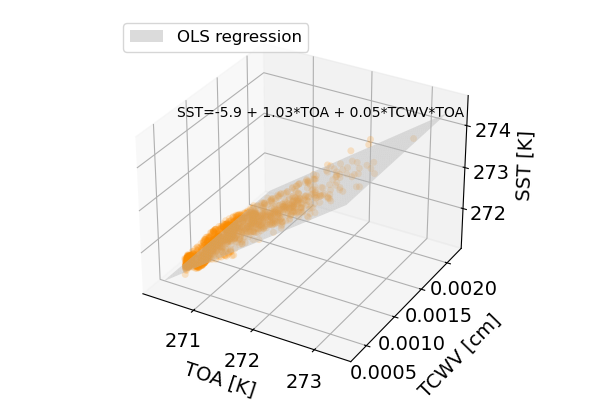

In [15]:
# Plot multiple linear regression in 3D

data = modtran_lut

# Generating predictions for a range of TOA and TCWV values
xi = np.linspace(data['TOA T[K]'].min(), data['TOA T[K]'].max(), 100)
wi = np.linspace(data['TCWV [cm]'].min(), data['TCWV [cm]'].max(), 100)
X, W = np.meshgrid(xi, wi)
Z_pred = NLSST_results.predict(exog=dict(toa=X.ravel(), tcwv_toa=(X*W).ravel())).values.reshape(X.shape)

# Create a figure and a 3D axes
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

ax.tick_params(labelsize=14)
ax.plot_surface(X,W,Z_pred,color='0.8', alpha=0.5,label='OLS regression',zorder=0)
ax.scatter(data['TOA T[K]'],data['TCWV [cm]'],data['Surface T[K]'],color='darkorange',linewidth=0,s=25,alpha=0.2,label='_no label_',zorder=2)
ax.text(270.3,0.0007,274.7,f'SST={a0} + {a1}*TOA + {a2}*TCWV*TOA',fontsize=10)
# a1.set_ylim([-3,2.5])
# a1.set_xlim([-3,2.5])
ax.set_xlabel('TOA [K]',labelpad=6,fontsize=14)
ax.set_ylabel('TCWV [cm]',labelpad=13,fontsize=14)
ax.set_zlabel('SST [K]',labelpad=6,fontsize=14)
ax.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

In [16]:
# # Info on MODIS atmospheric dataset (MOD/MYD07 Level 2)
# from pprint import pprint
# datasets = earthaccess.search_datasets(short_name="MOD07_L2",
#                                        cloud_hosted=True)

# for dataset in datasets:
#     pprint(dataset.summary())

## Search for desired Landsat scenes

In [18]:
# # Interpolation test values, keep scene [2:3]
# bbox = (-106.5, -75.0, -104.9, -74.7) #(west, south, east, north) 
# timeRange = '2019-02-06/2019-02-07'

# # [0:1] Cosgrove bbox
# timeRange = '2022-11-01/2023-03-27'

# # # [0:1] Dotson bbox
# timeRange = '2022-11-01/2023-03-27'

# Paper time span
# # Cosgrove full run 
# timeRange = '2021-09-01/2023-04-07'

# # Dotson full run
# timeRange = '2021-09-01/2023-05-31'

# Dotson intercomp run
timeRange = '2021-09-01/2023-03-31'

# timeRange = '2023-03-30/2023-03-31'
# timeRange = '2022-12-18/2022-12-19'
# timeRange = '2023-01-30/2023-01-31'

In [19]:
# Search for desired Landsat scenes
items = search_stac(url,bbox,timeRange,collection,gjson_outfile)

# Open stac catalog for some needed info
catalog = intake.open_stac_item_collection(items)

# Load the geojson file
gf = gpd.read_file(gjson_outfile)

388 items


In [20]:
# Plot tiles of all scenes found
plot_search(gf,satellite,colnm)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

## Process Landsat scenes to acquire sea surface temperature

In [21]:
# # Convert bounding box to polar for checking if landsat has any data in bounding box
# # Speeds up process a lot
# source_crs = 'epsg:4326' 
# target_crs = 'epsg:3031' # Coordinate system of the file

# topolar = pyproj.Transformer.from_crs(source_crs,target_crs)
# polarx,polary = topolar.transform([bbox[3],bbox[1]],[bbox[0],bbox[2]]) #LRX,LRY with ULX,ULY

# Convert bounding box to south polar stereo for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

sbox,checkbox = lsat_reproj(source_crs,target_crs,(bbox[0],bbox[1],bbox[2],bbox[3]))

# Create polygon for later cropping
polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

lsat_reproj normal orientation
bbox=[(-1593109.0801169195, -692703.5426974659), (-1583974.6675212178, -688731.7870628558), (-1587915.183520055, -679597.3747787862), (-1597072.3201527703, -683516.4543874896)]
lbox=(-113.5, -74.2, -113.17, -74.11)
checkbox=[-113.5   -74.2  -113.17  -74.11]


In [22]:
%%time  
## 1 min 1 sec per image without interpolation, 1 min 5 s with interp, no extra memory 
## With all clusters - 4 min 20 sec @ 15k, 4 min 6 sec @ 10k, 6 min 40 sec @ 5k

# Saves MODIS water vapor file name in COG so know what each image was corrected with

# Include only Landsat 8 scenes
catalog_list = [x for x in items if x.id[3]=='8']

for sceneid in catalog_list:
    print(sceneid.id)
    
    scene = catalog[sceneid.id]
    timestr = scene.metadata['datetime'].strftime('%H%M%S')

    outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'
    
    if os.path.isfile(outFile):
        print (f'{sceneid.id} - atm corr exists')

    else:
        # Open all desired bands for one scene
        ls_scene = landsat_to_xarray(sceneid)
        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

        # Create classification mask
        ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
        
        try:
            # Check for any open ocean pixels in bounding box - go to next image if none - 9.3 s
            mask = np.ones(ls_scene.shape[1:])
            mask[ls_scene.mask!=3] = np.nan
            ls_thermal = ls_scene.sel(band='lwir11').compute()
            ls_box = subset_img(ls_thermal*mask,polarx,polary)
            # ls_box = (ls_thermal*mask).sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))
            ls_box = ls_box.where(ls_box >= -3.5, np.nan)

            if ((ls_box).notnull()).sum().values==0:
                print (f'{sceneid.id} has no SSTs')
                try:
                    del ls_scene, scene, mask, ls_thermal, ls_box
                except:
                    pass
                gc.collect()
                continue
            
            # Use band ratios for RF cloud pixel classification
            # ###

            # Atmospheric correction using MODIS
            # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
            mod07,modfilenm = open_MODIS(ls_scene,scene,modout_path)

            # Create water vapor files aligned and subsampled to Landsat
            spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long, 1 must be negative for MODISlookup

            #***has not yet been tested to ensure no interp works properly
            WV_xr = get_wv2(ls_scene,mod07,spacing,WV,scene,interp=interp)
            # WV_xr = get_wv(ls_scene,mod07,spacing,WV)

            # Create SST by masking and using water vapor to apply month-specific atmospheric correction
            SST = apply_NLSST(ls_thermal,scene,mask,WV_xr,atmcor)

            # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
            # data variables in COG (click on white paper info button in xarray readout)
            SST.attrs['MODIS_WV'] = modfilenm

            print (f'Mean SST: {np.nanmean(SST)}')

            # Save to a cloud-optimized Geotiff
            SST.rio.to_raster(raster_path=outFile, driver="COG")
            
        except Exception as e:
            print (f'{sceneid.id} has no SSTs: {e}')
        
        try:
            del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST
        except:
            pass
        
        gc.collect()

LC08_L1GT_008113_20230518_20230524_02_T2
(437, 436)
LC08_L1GT_008113_20230518_20230524_02_T2 has no SSTs
LC08_L1GT_010113_20230516_20230523_02_T2
(437, 436)
LC08_L1GT_010113_20230516_20230523_02_T2 has no SSTs
LC08_L1GT_010112_20230516_20230523_02_T2
(437, 436)
LC08_L1GT_010112_20230516_20230523_02_T2 has no SSTs
LC08_L1GT_008113_20230502_20230509_02_T2
(437, 436)
LC08_L1GT_008113_20230502_20230509_02_T2 has no SSTs
LC08_L1GT_010113_20230430_20230509_02_T2
(437, 436)
LC08_L1GT_010113_20230430_20230509_02_T2 has no SSTs
LC08_L1GT_010112_20230430_20230509_02_T2
(437, 436)
LC08_L1GT_010112_20230430_20230509_02_T2 has no SSTs
LC08_L1GT_008113_20230416_20230428_02_T2
(437, 436)
LC08_L1GT_008113_20230416_20230428_02_T2 has no SSTs
LC08_L1GT_010113_20230414_20230428_02_T2
(437, 436)
LC08_L1GT_010113_20230414_20230428_02_T2 has no SSTs
LC08_L1GT_010112_20230414_20230428_02_T2
(437, 436)
LC08_L1GT_010112_20230414_20230428_02_T2 has no SSTs
LC08_L1GT_008113_20230331_20230411_02_T2
(437, 436)
LC0

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023083.1620.061.2023133002620.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 17801 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0001493260541799101, min: 7e-05, max: 0.00034
Mean SST: -4.765356130073946
LC08_L1GT_009113_20230322_20230404_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
TopologyException: side location conflict at -15.904953619622983 -74.006884273964346. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 04:38:53


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2023081.2020.061.2023133013827.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 29780 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0002000108755973204, min: 0.0002, max: 0.00021
Mean SST: -5.297800453237311
LC08_L1GT_011112_20230320_20230324_02_T2
(437, 436)
LC08_L1GT_011112_20230320_20230324_02_T2 has no SSTs
LC08_L1GT_008113_20230315_20230321_02_T2
(437, 436)
LC08_L1GT_008113_20230315_20230321_02_T2 has no SSTs
LC08_L1GT_010113_20230313_20230321_02_T2
(437, 436)
Granules found: 12
Granules found: 11
23 TOTAL granules
TopologyException: side location conflict at -93.095058371006601 -69.197956715509051. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -85.250271492216939 -73.095779100441433. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -53.102781023916009 -72.549838237814484. This can occur if the input geometry is invalid.
1 TOTAL granules w overlap
Time difference between MODIS and Land

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023072.1700.061.2023132123006.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 23846 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00030681640014505474, min: 0.00025, max: 0.00046
Mean SST: -2.8997439214587017
LC08_L1GT_010112_20230313_20230321_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
TopologyException: side location conflict at -93.095058371006601 -69.197956715509051. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -85.250271492216939 -73.095779100441433. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -53.102781023916009 -72.549838237814484. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:12:58


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023072.1700.061.2023132123006.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 23846 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00036136534849148095, min: 0.00027, max: 0.00051
Mean SST: -3.755535680802616
LC08_L1GT_012112_20230311_20230320_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -19.760947026140933 -74.504865022191964. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -69.566973045289842 -72.638790826326428. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -35.638886863516213 -72.234998551504617. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:15:36


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023070.1715.061.2023132080921.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 15125 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00038828422921883914, min: 0.00023, max: 0.00047
Mean SST: -2.6357757499866272
LC08_L1GT_007113_20230308_20230320_02_T2
(437, 436)
Granules found: 9
Granules found: 11
20 TOTAL granules
TopologyException: side location conflict at -13.726019776354603 -74.480649752001113. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -88.30370341256662 -72.53997148801281. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -53.693641481704326 -72.198020096334687. This can occur if the input geometry is invalid.
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 08:28:53


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2023067.0700.061.2023132081335.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 13453 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0003173513998084966, min: 0.0002, max: 0.00038
Mean SST: -3.1840796861062084
LC08_L1GT_009113_20230306_20230316_02_T2
(437, 436)
LC08_L1GT_009113_20230306_20230316_02_T2 has no SSTs
LC08_L1GT_011112_20230304_20230316_02_T2
(437, 436)
LC08_L1GT_011112_20230304_20230316_02_T2 has no SSTs
LC08_L1GT_008113_20230227_20230315_02_T2
(437, 436)
LC08_L1GT_008113_20230227_20230315_02_T2 has no SSTs
LC08_L1GT_010113_20230225_20230301_02_T2
(437, 436)
LC08_L1GT_010113_20230225_20230301_02_T2 has no SSTs
LC08_L1GT_010112_20230225_20230301_02_T2
(437, 436)
LC08_L1GT_010112_20230225_20230301_02_T2 has no SSTs
LC08_L1GT_012112_20230223_20230301_02_T2
(437, 436)
LC08_L1GT_012112_20230223_20230301_02_T2 has no SSTs
LC08_L1GT_007113_20230220_20230228_02_T2
(437, 436)
LC08_L1GT_007113_20230220_20230228_02_T2 has no SSTs
LC08_L1GT_009113_20230218_20230223_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
TopologyException: side

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023049.1600.061.2023131115339.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 22886 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0003930743710059933, min: 0.00021, max: 0.00055
Mean SST: -4.128849400395623
LC08_L1GT_011112_20230216_20230223_02_T2
(437, 436)
LC08_L1GT_011112_20230216_20230223_02_T2 has no SSTs
LC08_L1GT_008113_20230211_20230217_02_T2
(437, 436)
LC08_L1GT_008113_20230211_20230217_02_T2 has no SSTs
LC08_L1GT_010113_20230209_20230217_02_T2
(437, 436)
LC08_L1GT_010113_20230209_20230217_02_T2 has no SSTs
LC08_L1GT_010112_20230209_20230217_02_T2
(437, 436)
LC08_L1GT_010112_20230209_20230217_02_T2 has no SSTs
LC08_L1GT_012112_20230207_20230217_02_T2
(437, 436)
LC08_L1GT_012112_20230207_20230217_02_T2 has no SSTs
LC08_L1GT_007113_20230204_20230209_02_T2
(437, 436)
Granules found: 11
Granules found: 11
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -68.899918957014719 -73.204231922213765. This can occur if the input geometry is invalid.
TopologyException: 

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023035.1615.061.2023131005801.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 22034 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00032134233682164394, min: 0.00018, max: 0.00057
Mean SST: -4.8302492510164114
LC08_L1GT_009113_20230202_20230209_02_T2
(437, 436)
Granules found: 11
Granules found: 12
23 TOTAL granules
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:48:21


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023033.1630.061.2023130235640.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 20770 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.000542954525439598, min: 0.00036, max: 0.00074
Mean SST: -2.208434167619511
LC08_L1GT_011112_20230131_20230208_02_T2
(437, 436)
Granules found: 10
Granules found: 9
19 TOTAL granules
TopologyException: side location conflict at -43.391804864105268 -71.946864474080144. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -54.267319653464511 -76.432313780940916. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:51:23


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023031.1645.061.2023032023057.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 21141 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0005097379312868503, min: 0.00041, max: 0.0006
Mean SST: 0.055928339111851036
LC08_L1GT_010113_20230124_20230207_02_T2
(437, 436)
LC08_L1GT_010113_20230124_20230207_02_T2 has no SSTs
LC08_L1GT_010112_20230124_20230207_02_T2
(437, 436)
LC08_L1GT_010112_20230124_20230207_02_T2 has no SSTs
LC08_L1GT_012112_20230122_20230207_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -77.269443725564273 -73.641058747338903. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:29:45


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023022.1530.061.2023023012514.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 23853 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0004642508668596909, min: 0.00037, max: 0.00057
Mean SST: 0.09252617356724523
LC08_L1GT_007113_20230119_20230131_02_T2
(437, 436)
LC08_L1GT_007113_20230119_20230131_02_T2 has no SSTs
LC08_L1GT_009113_20230117_20230131_02_T2
(437, 436)
Granules found: 10
Granules found: 9
19 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -70.578176743537625 -74.901700249631133. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -28.938203977134688 -75.148317669355322. This can occur if the input geometry is invalid.
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 05:18:28


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2023017.2100.061.2023019061917.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 10811 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.000624929534690257, min: 0.00046, max: 0.00086
Mean SST: -0.7898538286309557
LC08_L1GT_011112_20230115_20230131_02_T2
(437, 436)
LC08_L1GT_011112_20230115_20230131_02_T2 has no SSTs
LC08_L1GT_164131_20230115_20230131_02_T2
(437, 436)
LC08_L1GT_164131_20230115_20230131_02_T2 has no SSTs
LC08_L1GT_166131_20230113_20230125_02_T2
(437, 436)
LC08_L1GT_166131_20230113_20230125_02_T2 has no SSTs
LC08_L1GT_008113_20230110_20230124_02_T2
(437, 436)
LC08_L1GT_008113_20230110_20230124_02_T2 has no SSTs
LC08_L1GT_010113_20230108_20230124_02_T2
(437, 436)
Granules found: 11
Granules found: 9
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -72.820952075391716 -72.277138144374419. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -55.899540353155565 -76.411663291540847. This can occur if the input geometry is

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023008.1545.061.2023009014215.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 25931 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0004244579499719584, min: 0.00029, max: 0.00054
Mean SST: -0.41081272022212834
LC08_L1GT_010112_20230108_20230124_02_T2
(437, 436)
Granules found: 10
Granules found: 10
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -72.820952075391716 -72.277138144374419. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -55.899540353155565 -76.411663291540847. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:02:27


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023008.1545.061.2023009014215.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 25931 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00045787063851624604, min: 0.00029, max: 0.0006
Mean SST: -0.7752541374514895
LC08_L1GT_163131_20230108_20230124_02_T2
(437, 436)
Granules found: 12
Granules found: 10
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -72.820952075391716 -72.277138144374419. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -57.997415315790072 -70.082505518821108. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -55.899540353155565 -76.411663291540847. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:09:22


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2023008.0750.061.2023008194318.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 16077 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00048082670182865537, min: 0.00036, max: 0.00056
Mean SST: -1.2479755290229164
LC08_L1GT_012112_20230106_20230110_02_T2
(437, 436)
LC08_L1GT_012112_20230106_20230110_02_T2 has no SSTs
LC08_L1GT_165131_20230106_20230110_02_T2
(437, 436)
LC08_L1GT_165131_20230106_20230110_02_T2 has no SSTs
LC08_L1GT_007113_20230103_20230111_02_T2
(437, 436)
LC08_L1GT_007113_20230103_20230111_02_T2 has no SSTs
LC08_L1GT_009113_20230101_20230110_02_T2
(437, 436)
LC08_L1GT_009113_20230101_20230110_02_T2 has no SSTs
LC08_L1GT_162132_20230101_20230110_02_T2
(437, 436)
LC08_L1GT_162132_20230101_20230110_02_T2 has no SSTs
LC08_L1GT_011112_20221230_20230110_02_T2
(437, 436)
LC08_L1GT_011112_20221230_20230110_02_T2 has no SSTs
LC08_L1GT_164131_20221230_20230110_02_T2
(437, 436)
LC08_L1GT_164131_20221230_20230110_02_T2 has no SSTs
LC08_L1GT_166131_20221228_20230104_02_T2
(437, 436)
LC08_L1GT_166131_20221228_20230104_02_T2 has no SSTs
LC08_L1GT_008113_2022122

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022359.2105.061.2022362062133.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 11794 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00040290484545561577, min: 0.00028, max: 0.00053
Mean SST: -0.5064119881863048
LC08_L1GT_010113_20221223_20230103_02_T2
(437, 436)
LC08_L1GT_010113_20221223_20230103_02_T2 has no SSTs
LC08_L1GT_010112_20221223_20230103_02_T2
(437, 436)
LC08_L1GT_010112_20221223_20230103_02_T2 has no SSTs
LC08_L1GT_163131_20221223_20230103_02_T2
(437, 436)
LC08_L1GT_163131_20221223_20230103_02_T2 has no SSTs
LC08_L1GT_012112_20221221_20221228_02_T2
(437, 436)
Granules found: 10
Granules found: 9
19 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -81.655613099616275 -72.462484698011281. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 02:05:12


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022355.1805.061.2022356090845.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 2996 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0004033182794735411, min: 0.00028, max: 0.00051
Mean SST: -0.9731001003279602
LC08_L1GT_165131_20221221_20221228_02_T2
(437, 436)
Granules found: 11
Granules found: 11
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -81.655613099616275 -72.462484698011281. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -84.638831933271803 -69.607423323617155. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -61.653994441027493 -70.199297647017119. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:17:00


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022355.0810.061.2022356005130.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 24436 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00037989645652708877, min: 0.00027, max: 0.00054
Mean SST: -1.7123787349847706
LC08_L1GT_007113_20221218_20230113_02_T2
(437, 436)
LC08_L1GT_007113_20221218_20230113_02_T2 has no SSTs
LC08_L1GT_009113_20221216_20221227_02_T2
(437, 436)
LC08_L1GT_009113_20221216_20221227_02_T2 has no SSTs
LC08_L1GT_162132_20221216_20221227_02_T2
(437, 436)
LC08_L1GT_162132_20221216_20221227_02_T2 has no SSTs
LC08_L1GT_011112_20221214_20221223_02_T2
(437, 436)
LC08_L1GT_011112_20221214_20221223_02_T2 has no SSTs
LC08_L1GT_164131_20221214_20221219_02_T2
(437, 436)
LC08_L1GT_164131_20221214_20221219_02_T2 has no SSTs
LC08_L1GT_166131_20221212_20230113_02_T2
(437, 436)
LC08_L1GT_166131_20221212_20230113_02_T2 has no SSTs
LC08_L1GT_008113_20221209_20221219_02_T2
(437, 436)
LC08_L1GT_008113_20221209_20221219_02_T2 has no SSTs
LC08_L1GT_010113_20221207_20221213_02_T2
(437, 436)
LC08_L1GT_010113_20221207_20221213_02_T2 has no SSTs
LC08_L1GT_010112_2022120

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022341.0805.061.2022341194103.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 26674 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.000493582461178386, min: 0.00038, max: 0.00063
Mean SST: -6.689744757999303
LC08_L1GT_012112_20221205_20230112_02_T2
(437, 436)
LC08_L1GT_012112_20221205_20230112_02_T2 has no SSTs
LC08_L1GT_165131_20221205_20230113_02_T2
(437, 436)
LC08_L1GT_165131_20221205_20230113_02_T2 has no SSTs
LC08_L1GT_007113_20221202_20221212_02_T2
(437, 436)
Granules found: 11
Granules found: 11
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -79.509108039813214 -70.720946242456833. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -100.10364579218421 -66.98363905040722. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 06:04:29


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022336.0925.061.2022336203844.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 25350 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0003610111687562073, min: 0.00021, max: 0.00046
Mean SST: -1.2647916419712104
LC08_L1GT_009113_20221130_20221206_02_T2
(437, 436)
Granules found: 11
Granules found: 9
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -39.47752806344473 -74.24764003053626. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -74.142950098887994 -75.013259957210224. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:31:50


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022334.1510.061.2022335213004.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 47958 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0002609252974043397, min: 0.0002, max: 0.00036
Mean SST: -3.687871046273832
LC08_L1GT_162132_20221130_20221206_02_T2
(437, 436)
Granules found: 11
Granules found: 11
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -39.47752806344473 -74.24764003053626. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -74.142950098887994 -75.013259957210224. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:24:59


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022334.0800.061.2022334231805.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 42246 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00029520652161238757, min: 0.00021, max: 0.00034
Mean SST: -3.778510248592638
LC08_L1GT_011112_20221128_20221206_02_T2
(437, 436)
LC08_L1GT_011112_20221128_20221206_02_T2 has no SSTs
LC08_L1GT_164131_20221128_20221206_02_T2
(437, 436)
LC08_L1GT_164131_20221128_20221206_02_T2 has no SSTs
LC08_L1GT_166131_20221126_20221206_02_T2
(437, 436)
Granules found: 10
Granules found: 9
19 TOTAL granules
TopologyException: side location conflict at -109.1968021174703 -65.901148591468669. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -25.540221133201435 -73.444800859433386. This can occur if the input geometry is invalid.
1 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:24:20


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022330.0735.061.2022330200555.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 52955 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00023361724396194, min: 0.00016, max: 0.00034
Mean SST: -3.829942904095995
LC08_L1GT_008113_20221123_20221205_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -60.891637355258723 -74.642492808271257. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -109.28799622997929 -64.899222038115852. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 05:39:22


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022327.2115.061.2022328170726.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 21541 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.000357434926112433, min: 0.00022, max: 0.00043
Mean SST: -4.624720053762684
LC08_L1GT_010113_20221121_20221129_02_T2
(437, 436)
LC08_L1GT_010113_20221121_20221129_02_T2 has no SSTs
LC08_L1GT_010112_20221121_20221129_02_T2
(437, 436)
LC08_L1GT_010112_20221121_20221129_02_T2 has no SSTs
LC08_L1GT_012112_20221119_20221128_02_T2
(437, 436)
LC08_L1GT_012112_20221119_20221128_02_T2 has no SSTs
LC08_L1GT_007113_20221116_20221128_02_T2
(437, 436)
Granules found: 12
Granules found: 9
21 TOTAL granules
TopologyException: side location conflict at -91.781320826281686 -69.247650370779041. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -72.898624505954587 -69.815511450771112. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -101.90389166763251 -70.597232198565351. This can occur if the input geometry is invalid.
TopologyException: side location conflic

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022320.1700.061.2022336122538.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 15866 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00015297320343160182, min: 0.00012, max: 0.00019
Mean SST: -4.52214055922159
LC08_L1GT_009113_20221114_20221122_02_T2
(437, 436)
Granules found: 9
Granules found: 8
17 TOTAL granules
TopologyException: side location conflict at -34.600633792687852 -73.186137043449065. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:33:10


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022318.1715.061.2022336035325.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 12228 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00014266459548182352, min: 0.00012, max: 0.00019
Mean SST: -5.6758825925445135
LC08_L1GT_011112_20221112_20230113_02_T2
(437, 436)
Granules found: 10
Granules found: 10
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -80.587888719893499 -71.797249102628214. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -53.365307411160273 -75.12199930976368. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -5.2482607526920759 -75.938080137813699. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time diff

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022316.2140.061.2022317180448.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 7272 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00034707120400043597, min: 0.00028, max: 0.00043
Mean SST: -7.680132890887002
LC08_L1GT_008113_20221107_20221115_02_T2
(437, 436)
LC08_L1GT_008113_20221107_20221115_02_T2 has no SSTs
LC08_L1GT_010113_20221105_20221115_02_T2
(437, 436)
Granules found: 9
Granules found: 9
18 TOTAL granules
TopologyException: side location conflict at -107.34277586546435 -71.749619412089814. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:11:54


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022309.1600.061.2022335002055.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 26568 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00018436190434884556, min: 0.00013, max: 0.00022
Mean SST: -4.301428332335805
LC08_L1GT_010112_20221105_20221115_02_T2
(437, 436)
Granules found: 10
Granules found: 9
19 TOTAL granules
TopologyException: side location conflict at -107.34277586546435 -71.749619412089814. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:12:18


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022309.1600.061.2022335002055.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 26568 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.000254135312806142, min: 0.00017, max: 0.00037
Mean SST: -4.437787796966573
LC08_L1GT_012112_20221103_20221114_02_T2
(437, 436)
LC08_L1GT_012112_20221103_20221114_02_T2 has no SSTs
LC08_L1GT_007113_20221031_20221108_02_T2
(437, 436)
LC08_L1GT_007113_20221031_20221108_02_T2 has no SSTs
LC08_L1GT_009113_20221029_20221108_02_T2
(437, 436)
LC08_L1GT_009113_20221029_20221108_02_T2 has no SSTs
LC08_L1GT_011112_20221027_20221108_02_T2
(437, 436)
LC08_L1GT_011112_20221027_20221108_02_T2 has no SSTs
LC08_L1GT_008113_20221022_20221101_02_T2
(437, 436)
Granules found: 0
Granules found: 11
11 TOTAL granules
TopologyException: side location conflict at -103.35762733937307 -70.802967260134736. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -55.217683302114594 -71.553826203078017. This can occur if the input geometry is invalid.
0 TOTAL granules w overlap
LC08_L1GT_008113_20221022_20221101_02_T2 ha

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022293.2140.061.2022294163427.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 36884 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00021346525119375682, min: 0.00015, max: 0.00037
Mean SST: -5.02421701378042
LC08_L1GT_010112_20221020_20221101_02_T2
(437, 436)
Granules found: 0
Granules found: 8
8 TOTAL granules
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 05:52:22


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022293.2140.061.2022294163427.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 36884 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00026196399332194524, min: 0.00016, max: 0.00037
Mean SST: -5.249290267117644
LC08_L1GT_012112_20221018_20221031_02_T2
(437, 436)
Granules found: 0
Granules found: 11
11 TOTAL granules
TopologyException: side location conflict at -58.087251080848723 -75.059366165195783. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -9.1880432288503009 -75.942103009359442. This can occur if the input geometry is invalid.
1 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 05:55:02


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022291.2155.061.2022292212245.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 13010 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 8.98250229071678e-05, min: 5e-05, max: 0.00023
Mean SST: -5.572842164769378
LC08_L1GT_007113_20221015_20221021_02_T2
(437, 436)
LC08_L1GT_007113_20221015_20221021_02_T2 has no SSTs
LC08_L1GT_011112_20221011_20221020_02_T2
(437, 436)
LC08_L1GT_011112_20221011_20221020_02_T2 has no SSTs
LC08_L1GT_008113_20221006_20221013_02_T2
(437, 436)
LC08_L1GT_008113_20221006_20221013_02_T2 has no SSTs
LC08_L1GT_010113_20221004_20221012_02_T2
(437, 436)
LC08_L1GT_010113_20221004_20221012_02_T2 has no SSTs
LC08_L1GT_010112_20221004_20221012_02_T2
(437, 436)
LC08_L1GT_010112_20221004_20221012_02_T2 has no SSTs
LC08_L1GT_012112_20221002_20221012_02_T2
(437, 436)
LC08_L1GT_012112_20221002_20221012_02_T2 has no SSTs
LC08_L1GT_007113_20220929_20221004_02_T2
(437, 436)
Granules found: 11
Granules found: 9
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -42.7915

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022272.1755.061.2022273021013.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 9383 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00014823047031167527, min: 0.00011, max: 0.00019
Mean SST: -4.615995009799391
LC08_L1GT_009113_20220927_20221004_02_T2
(437, 436)
LC08_L1GT_009113_20220927_20221004_02_T2 has no SSTs
LC08_L1GT_011112_20220925_20221004_02_T2
(437, 436)
LC08_L1GT_011112_20220925_20221004_02_T2 has no SSTs
LC08_L1GT_008113_20220920_20220928_02_T2
(437, 436)
LC08_L1GT_008113_20220920_20220928_02_T2 has no SSTs
LC08_L1GT_010113_20220918_20220928_02_T2
(437, 436)
LC08_L1GT_010113_20220918_20220928_02_T2 has no SSTs
LC08_L1GT_010112_20220918_20220928_02_T2
(437, 436)
LC08_L1GT_010112_20220918_20220928_02_T2 has no SSTs
LC08_L1GT_010113_20220326_20220329_02_T2
(437, 436)
LC08_L1GT_010113_20220326_20220329_02_T2 has no SSTs
LC08_L1GT_010112_20220326_20220329_02_T2
(437, 436)
LC08_L1GT_010112_20220326_20220329_02_T2 has no SSTs
LC08_L1GT_012112_20220324_20220329_02_T2
(437, 436)
Granules found: 10
Granules found: 10
20 TOTAL granules
5 TOTAL granules w ove

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022083.1655.061.2022091203539.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 24787 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00030139980779517346, min: 4e-05, max: 0.00047
Mean SST: -6.9188663740520235
LC08_L1GT_007113_20220321_20220329_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -60.703404576727664 -73.7843182936045. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
6 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:56:14


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022080.1625.061.2022091192638.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 32887 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0001296337627676229, min: 0.0001, max: 0.00024
Mean SST: -8.292530463993465
LC08_L1GT_009113_20220319_20220329_02_T2
(437, 436)
LC08_L1GT_009113_20220319_20220329_02_T2 has no SSTs
LC08_L1GT_011112_20220317_20220321_02_T2
(437, 436)
LC08_L1GT_011112_20220317_20220321_02_T2 has no SSTs
LC08_L1GT_008113_20220312_20220321_02_T2
(437, 436)
Granules found: 10
Granules found: 10
20 TOTAL granules
TopologyException: side location conflict at -69.320000398155955 -75.264003549828175. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -51.997331159092113 -70.796925405479485. This can occur if the input geometry is invalid.
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:54:57


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022071.1630.061.2022072013420.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 16959 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00040278327096769217, min: 0.00026, max: 0.00057
Mean SST: -2.8275667638781172
LC08_L1GT_010113_20220310_20220321_02_T2
(437, 436)
LC08_L1GT_010113_20220310_20220321_02_T2 has no SSTs
LC08_L1GT_010112_20220310_20220321_02_T2
(437, 436)
LC08_L1GT_010112_20220310_20220321_02_T2 has no SSTs
LC08_L1GT_012112_20220308_20220315_02_T2
(437, 436)
LC08_L1GT_012112_20220308_20220315_02_T2 has no SSTs
LC08_L1GT_007113_20220305_20220315_02_T2
(437, 436)
LC08_L1GT_007113_20220305_20220315_02_T2 has no SSTs
LC08_L1GT_009113_20220303_20220315_02_T2
(437, 436)
LC08_L1GT_009113_20220303_20220315_02_T2 has no SSTs
LC08_L1GT_011112_20220301_20220309_02_T2
(437, 436)
LC08_L1GT_011112_20220301_20220309_02_T2 has no SSTs
LC08_L1GT_008113_20220224_20220301_02_T2
(437, 436)
LC08_L1GT_008113_20220224_20220301_02_T2 has no SSTs
LC08_L1GT_010113_20220222_20220302_02_T2
(437, 436)
LC08_L1GT_010113_20220222_20220302_02_T2 has no SSTs
LC08_L1GT_010112_2022022

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022046.1815.061.2022047073747.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 1288 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0003529142086765132, min: 0.00031, max: 0.0004
Mean SST: -4.0168203788829455
LC08_L1GT_011112_20220213_20220222_02_T2
(437, 436)
Granules found: 10
Granules found: 12
22 TOTAL granules
TopologyException: side location conflict at -92.668563068504611 -68.358884278024348. This can occur if the input geometry is invalid.
6 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:56:41


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022044.1650.061.2022045014000.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 21653 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0005950158553642066, min: 0.00022, max: 0.00077
Mean SST: -2.7703480338701185
LC08_L1GT_008113_20220208_20220222_02_T2
(437, 436)
LC08_L1GT_008113_20220208_20220222_02_T2 has no SSTs
LC08_L1GT_010113_20220206_20220212_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -77.482062022464106 -72.78940514976712. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 04:57:25


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022037.2045.061.2022039044045.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 15766 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00037991206334726183, min: 0.00037, max: 0.00038
Mean SST: -4.712847577225802
LC08_L1GT_010112_20220206_20220212_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -77.482062022464106 -72.78940514976712. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 04:57:49


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2022037.2045.061.2022039044045.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 15766 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0004020215368030287, min: 0.00038, max: 0.00045
Mean SST: -3.0324575209723044
LC08_L1GT_012112_20220204_20220212_02_T2
(437, 436)
Granules found: 10
Granules found: 12
22 TOTAL granules
TopologyException: side location conflict at -47.660103711404474 -71.47032415954871. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -73.636246009313155 -72.699547281970808. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -10.313135744425333 -74.746611891066436. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -88.85422959428395 -70.363768171879386. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:55:27


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022035.1655.061.2022036015933.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 10428 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0004053039533595489, min: 0.0003, max: 0.00056
Mean SST: -2.53562196155056
LC08_L1GT_007113_20220201_20220211_02_T2
(437, 436)
Granules found: 10
Granules found: 10
20 TOTAL granules
TopologyException: side location conflict at -73.849898347006132 -74.746787263220284. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -44.052797250269762 -71.34184931072609. This can occur if the input geometry is invalid.
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:55:57


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022032.1625.061.2022033033552.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 20841 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0003382060608716217, min: 0.00025, max: 0.00052
Mean SST: -3.462095777699014
LC08_L1GT_009113_20220130_20220204_02_T2
(437, 436)
LC08_L1GT_009113_20220130_20220204_02_T2 has no SSTs
LC08_L1GT_011112_20220128_20220204_02_T2
(437, 436)
LC08_L1GT_011112_20220128_20220204_02_T2 has no SSTs
LC08_L1GT_008113_20220123_20220128_02_T2
(437, 436)
LC08_L1GT_008113_20220123_20220128_02_T2 has no SSTs
LC08_L1GT_010113_20220121_20220128_02_T2
(437, 436)
Granules found: 10
Granules found: 12
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -58.985636065494141 -74.3061486407681. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:57:22


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022021.1645.061.2022022153414.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 26890 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0003753412571544747, min: 0.00031, max: 0.00051
Mean SST: -0.5608149419054509
LC08_L1GT_010112_20220121_20220128_02_T2
(437, 436)
Granules found: 11
Granules found: 11
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -58.985636065494141 -74.3061486407681. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:57:46


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022021.1645.061.2022022153414.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 26890 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00041410835175725174, min: 0.00035, max: 0.00058
Mean SST: -0.8396643415836282
LC08_L1GT_012112_20220119_20220127_02_T2
(437, 436)
LC08_L1GT_012112_20220119_20220127_02_T2 has no SSTs
LC08_L1GT_007113_20220116_20220123_02_T2
(437, 436)
LC08_L1GT_007113_20220116_20220123_02_T2 has no SSTs
LC08_L1GT_009113_20220114_20220123_02_T2
(437, 436)
LC08_L1GT_009113_20220114_20220123_02_T2 has no SSTs
LC08_L1GT_011112_20220112_20220123_02_T2
(437, 436)
Granules found: 11
Granules found: 11
22 TOTAL granules
TopologyException: side location conflict at -55.649350446412143 -70.916550049792122. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:56:32


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022012.1650.061.2022014143923.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 14873 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0004565753576004292, min: 0.00027, max: 0.00055
Mean SST: -1.4555920344211697
LC08_L1GT_164131_20220112_20220122_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -39.49816889502484 -73.347760163459185. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:41:39


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022012.0705.061.2022014144112.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 22899 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0005212184614113375, min: 0.00035, max: 0.00066
Mean SST: -2.201994394403448
LC08_L1GT_166131_20220110_20220114_02_T2
(437, 436)
LC08_L1GT_166131_20220110_20220114_02_T2 has no SSTs
LC08_L1GT_008113_20220107_20220114_02_T2
(437, 436)
Granules found: 13
Granules found: 10
23 TOTAL granules
TopologyException: side location conflict at -74.508378444934579 -70.79854706825445. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -43.55323586057915 -74.687401228663333. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -59.856169772663804 -72.192432907421633. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 02:34:40


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022007.1810.061.2022008073300.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 7490 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00026111816740880683, min: 0.00019, max: 0.00034
Mean SST: -0.34471077547797063
LC08_L1GT_010113_20220105_20220114_02_T2
(437, 436)
Granules found: 11
Granules found: 12
23 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -36.455060709572848 -76.232068406754507. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:57:18


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022005.1645.061.2022006014331.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 23566 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0004293307134965591, min: 0.0003, max: 0.00063
Mean SST: -0.6767975192868273
LC08_L1GT_010112_20220105_20220114_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -36.455060709572848 -76.232068406754507. This can occur if the input geometry is invalid.
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:57:42


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022005.1645.061.2022006014331.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 23566 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0005071427664076296, min: 0.00032, max: 0.00065
Mean SST: -0.9892780355242181
LC08_L1GT_163131_20220105_20220114_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -36.455060709572848 -76.232068406754507. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:40:29


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2022005.0700.061.2022005193355.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 26973 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00010150060250362052, min: 7e-05, max: 0.00021
Mean SST: -2.3502219173869543
LC08_L1GT_012112_20220103_20220113_02_T2
(437, 436)
LC08_L1GT_012112_20220103_20220113_02_T2 has no SSTs
LC08_L1GT_165131_20220103_20220114_02_T2
(437, 436)
LC08_L1GT_165131_20220103_20220114_02_T2 has no SSTs
LC08_L1GT_007113_20211231_20220105_02_T2
(437, 436)
LC08_L1GT_007113_20211231_20220105_02_T2 has no SSTs
LC08_L1GT_009113_20211229_20220105_02_T2
(437, 436)
LC08_L1GT_009113_20211229_20220105_02_T2 has no SSTs
LC08_L1GT_162132_20211229_20220105_02_T2
(437, 436)
LC08_L1GT_162132_20211229_20220105_02_T2 has no SSTs
LC08_L1GT_011112_20211227_20220105_02_T2
(437, 436)
Granules found: 11
Granules found: 12
23 TOTAL granules
TopologyException: side location conflict at -82.643236316473505 -70.042123811194628. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -55.834055534342255 -70.700785065285544. This can occ

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021361.1650.061.2021362014701.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 10724 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0005302786522713798, min: 0.00037, max: 0.00066
Mean SST: -1.6187183720266383
LC08_L1GT_164131_20211227_20220105_02_T2
(437, 436)
Granules found: 10
Granules found: 8
18 TOTAL granules
TopologyException: side location conflict at -82.643236316473505 -70.042123811194628. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -55.834055534342255 -70.700785065285544. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -43.265777099790803 -73.036892165861701. This can occur if the input geometry is invalid.
1 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:23:18


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2021361.0910.061.2021361193743.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 5957 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00036715644393844985, min: 0.00031, max: 0.00043
Mean SST: -0.8051482715916727
LC08_L1GT_166131_20211225_20211229_02_T2
(437, 436)
LC08_L1GT_166131_20211225_20211229_02_T2 has no SSTs
LC08_L1GT_008113_20211222_20211230_02_T2
(437, 436)
Granules found: 12
Granules found: 11
23 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -54.29879399340772 -72.409172219707699. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -48.84746444720971 -74.239071554940054. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -64.173976047671289 -71.843028434504376. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 02:34:36


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021356.1810.061.2021357074030.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 16896 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0003922066906495173, min: 0.00033, max: 0.00055
Mean SST: -0.41876950987589556
LC08_L1GT_010113_20211220_20211229_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:57:13


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021354.1645.061.2021355024506.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 22950 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00048112839265942656, min: 0.00036, max: 0.00055
Mean SST: -0.39153789980931736
LC08_L1GT_010112_20211220_20211229_02_T2
(437, 436)
Granules found: 10
Granules found: 9
LC08_L1GT_010112_20211220_20211229_02_T2 has no SSTs: <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
</body>
</html>

LC08_L1GT_163131_20211220_20211229_02_T2
(437, 436)
Granules found: 12
LC08_L1GT_163131_20211220_20211229_02_T2 has no SSTs: <html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
</body>
</html>

LC08_L1GT_012112_20211218_20211223_02_T2
(437, 436)
LC08_L1GT_012112_20211218_20211223_02_T2 has no SSTs
LC08_L1GT_165131_20211218_20211223_02_T2
(437, 436)
LC08_L1GT_165131_20211218_20211223_02_T2 has no SSTs
LC08_L1GT_007113_20211215_20211223_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
TopologyException: side location 

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2021343.0745.061.2021343194747.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 25235 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00022342184218421797, min: 8e-05, max: 0.00043
Mean SST: -15.785591984227782
LC08_L1GT_008113_20211206_20211215_02_T2
(437, 436)
LC08_L1GT_008113_20211206_20211215_02_T2 has no SSTs
LC08_L1GT_010113_20211204_20211214_02_T2
(437, 436)
LC08_L1GT_010113_20211204_20211214_02_T2 has no SSTs
LC08_L1GT_010112_20211204_20211214_02_T2
(437, 436)
LC08_L1GT_010112_20211204_20211214_02_T2 has no SSTs
LC08_L1GT_163131_20211204_20211208_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
TopologyException: side location conflict at -38.996605787296772 -71.253209778625759. This can occur if the input geometry is invalid.
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:40:36


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021338.0700.061.2021338193914.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 36353 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00016616422584055175, min: 8e-05, max: 0.00027
Mean SST: -15.260258230925912
LC08_L1GT_012112_20211202_20211209_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -48.060028944933997 -73.390774915009899. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -87.694536523549573 -71.567479332334301. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -23.628229997508399 -73.633390643004248. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:39:47


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021336.1520.061.2021337013922.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 31834 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00030411119886469996, min: 0.00023, max: 0.00044
Mean SST: -1.1557999523505238
LC08_L1GT_007113_20211129_20211208_02_T2
(437, 436)
Granules found: 12
Granules found: 10
22 TOTAL granules
TopologyException: side location conflict at -79.492247410047852 -70.285163382184763. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -59.761984979945609 -70.126723509238573. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 02:35:43


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021333.1805.061.2021334075038.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 9362 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00026118245842559457, min: 0.00021, max: 0.00036
Mean SST: -4.144002730414525
LC08_L1GT_009113_20211127_20211208_02_T2
(437, 436)
LC08_L1GT_009113_20211127_20211208_02_T2 has no SSTs
LC08_L1GT_011112_20211125_20211201_02_T2
(437, 436)
LC08_L1GT_011112_20211125_20211201_02_T2 has no SSTs
LC08_L1GT_008113_20211120_20211130_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -12.216986359364324 -75.920952472114351. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -93.44565625552589 -71.257366920618466. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -68.288285952490526 -72.612023603188433. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -83.354729978855772

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2021324.2035.061.2021325154004.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 25904 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00035682275630329307, min: 0.00026, max: 0.00048
Mean SST: -3.879988351762361
LC08_L1GT_010113_20211118_20211125_02_T2
(437, 436)
LC08_L1GT_010113_20211118_20211125_02_T2 has no SSTs
LC08_L1GT_010112_20211118_20211125_02_T2
(437, 436)
LC08_L1GT_010112_20211118_20211125_02_T2 has no SSTs
LC08_L1GT_012112_20211116_20211125_02_T2
(437, 436)
Granules found: 10
Granules found: 10
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -28.949410796540779 -75.012805312924996. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -108.3899962970972 -70.563404447446018. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -88.307807397187048 -71.526905904709736. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -25.151418816082042

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021320.1520.061.2021321023228.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 23748 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00018195090991048404, min: 0.0001, max: 0.00036
Mean SST: -4.603861967894912
LC08_L1GT_007113_20211113_20211125_02_T2
(437, 436)
LC08_L1GT_007113_20211113_20211125_02_T2 has no SSTs
LC08_L1GT_009113_20211111_20211117_02_T2
(437, 436)
Granules found: 12
Granules found: 10
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -93.18412616134718 -72.756097271163398. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -29.980169630432499 -74.793267941347651. This can occur if the input geometry is invalid.
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:58:21


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021315.1640.061.2021316014228.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 17280 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00018551531793123757, min: 0.00012, max: 0.00028
Mean SST: -5.864286808872649
LC08_L1GT_011112_20211109_20211117_02_T2
(437, 436)
LC08_L1GT_011112_20211109_20211117_02_T2 has no SSTs
LC08_L1GT_008113_20211104_20211116_02_T2
(437, 436)
LC08_L1GT_008113_20211104_20211116_02_T2 has no SSTs
LC08_L1GT_010113_20211102_20211109_02_T2
(437, 436)
LC08_L1GT_010113_20211102_20211109_02_T2 has no SSTs
LC08_L1GT_010112_20211102_20211109_02_T2
(437, 436)
LC08_L1GT_010112_20211102_20211109_02_T2 has no SSTs
LC08_L1GT_012112_20211031_20211109_02_T2
(437, 436)
Granules found: 9
Granules found: 9
18 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -13.278597023220279 -76.369287442428018. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -95.441267987158469 -71.588239312200031. This can occur if the input geometry is

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021304.1520.061.2021305014140.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 20373 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00032931369764908517, min: 0.00023, max: 0.0004
Mean SST: -3.8870837838361747
LC08_L1GT_007113_20211028_20211108_02_T2
(437, 436)
Granules found: 12
Granules found: 11
23 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -49.952290939917845 -72.631759768630673. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 02:35:39


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021301.1805.061.2021302074543.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 11782 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00013554442239813438, min: 0.00013, max: 0.00014
Mean SST: -4.418638107158044
LC08_L1GT_009113_20211026_20211104_02_T2
(437, 436)
LC08_L1GT_009113_20211026_20211104_02_T2 has no SSTs
LC08_L1GT_011112_20211024_20211103_02_T2
(437, 436)
LC08_L1GT_011112_20211024_20211103_02_T2 has no SSTs
LC08_L1GT_008113_20211019_20211026_02_T2
(437, 436)
Granules found: 11
Granules found: 11
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -62.258631967019099 -73.774363167497043. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -82.101931886032503 -71.53473529578207. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -19.349359346746503 -73.482074332697849. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Lan

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021292.1635.061.2021293013708.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 28621 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00017933321771458415, min: 0.0001, max: 0.0003
Mean SST: -5.9996676509241516
LC08_L1GT_010113_20211017_20211026_02_T2
(437, 436)
Granules found: 11
Granules found: 10
21 TOTAL granules
TopologyException: side location conflict at -33.181723285707577 -72.356710212702893. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 04:57:07


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2021290.2045.061.2021291154257.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 22280 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.0002685539521510336, min: 0.00024, max: 0.00031
Mean SST: -4.706450157685039
LC08_L1GT_010112_20211017_20211026_02_T2
(437, 436)
Granules found: 10
Granules found: 10
20 TOTAL granules
TopologyException: side location conflict at -33.181723285707577 -72.356710212702893. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 04:57:31


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2021290.2045.061.2021291154257.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 22280 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00021618207665299478, min: 0.00016, max: 0.00032
Mean SST: -5.658506945953926
LC08_L1GT_012112_20211015_20211025_02_T2
(437, 436)
LC08_L1GT_012112_20211015_20211025_02_T2 has no SSTs
LC08_L1GT_007113_20211012_20211019_02_T2
(437, 436)
LC08_L1GT_007113_20211012_20211019_02_T2 has no SSTs
LC08_L1GT_009113_20211010_20211019_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
TopologyException: side location conflict at -74.315845662092102 -74.964907519702152. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -103.66421447065744 -71.914800091576083. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -40.48427003525218 -73.915769632982901. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Lan

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2021283.1640.061.2021284014559.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 12853 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00015498620248981652, min: 0.00014, max: 0.00017
Mean SST: -4.785744677057773
LC08_L1GT_011112_20211008_20211018_02_T2
(437, 436)
LC08_L1GT_011112_20211008_20211018_02_T2 has no SSTs
LC08_L1GT_008113_20211003_20211013_02_T2
(437, 436)
LC08_L1GT_008113_20211003_20211013_02_T2 has no SSTs
LC08_L1GT_010113_20211001_20211013_02_T2
(437, 436)
LC08_L1GT_010113_20211001_20211013_02_T2 has no SSTs
LC08_L1GT_010112_20211001_20211013_02_T2
(437, 436)
LC08_L1GT_010112_20211001_20211013_02_T2 has no SSTs
LC08_L1GT_012112_20210929_20211013_02_T2
(437, 436)
LC08_L1GT_012112_20210929_20211013_02_T2 has no SSTs
LC08_L1GT_007113_20210926_20210930_02_T2
(437, 436)
Granules found: 10
Granules found: 11
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -12.702706079595529 -75.740593506126658. This can occur if the input geometry is invalid.
TopologyException:

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2021269.2205.061.2021271004011.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 40988 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00018798283260292704, min: 8e-05, max: 0.00025
Mean SST: -4.434479144241836
LC08_L1GT_009113_20210924_20210930_02_T2
(437, 436)
LC08_L1GT_009113_20210924_20210930_02_T2 has no SSTs
LC08_L1GT_011112_20210922_20210930_02_T2
(437, 436)
Granules found: 4
Granules found: 12
16 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 06:36:28


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MYD07_L2.A2021265.2230.061.2021266153524.hdf.nc4']


surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 34744 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Latitude in proper position
Mean water vapor value is: 0.00018868701980705754, min: 0.00013, max: 0.00031
Mean SST: -4.54808118808122
LC08_L1GT_008113_20210917_20210924_02_T2
(437, 436)
LC08_L1GT_008113_20210917_20210924_02_T2 has no SSTs
LC08_L1GT_010113_20210915_20210924_02_T2
(437, 436)
LC08_L1GT_010113_20210915_20210924_02_T2 has no SSTs
LC08_L1GT_010112_20210915_20210924_02_T2
(437, 436)
LC08_L1GT_010112_20210915_20210924_02_T2 has no SSTs
LC08_L1GT_012112_20210913_20210924_02_T2
(437, 436)
LC08_L1GT_012112_20210913_20210924_02_T2 has no SSTs
CPU times: user 1h 9min 15s, sys: 8min 29s, total: 1h 17min 44s
Wall time: 2h 12min 8s


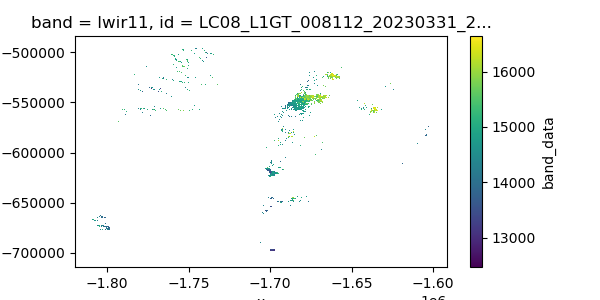

In [26]:
plt.figure(figsize=(6, 3))
(ls_thermal*mask).plot.imshow(x='x',y='y')
# (ls_scene.sel(band='qa_pixel').compute()*mask).plot.imshow(x='x',y='y')
# plt.imshow(mask)

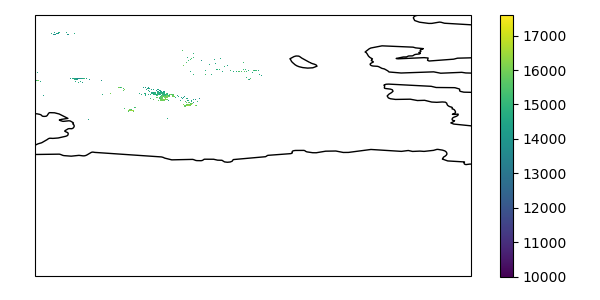

In [24]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = ls_thermal*mask
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=10000,vmax=17600,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

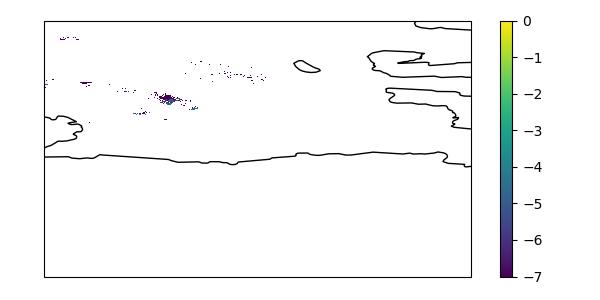

In [34]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = SST
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=-7,vmax=0,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

## Testing code

In [21]:
# Get date/time for Landsat image and search for corresponding MODIS imagery  
# ls_time = ls_scene.time.values.item()

# Get spatial extent of Landsat scene in lat/lon
mbbox = (scene.metadata['bbox'][0], scene.metadata['bbox'][1], scene.metadata['bbox'][2], scene.metadata['bbox'][3]) #(west, south, east, north) 
lsatpoly = Polygon([(mbbox[0],mbbox[1]),(mbbox[0],mbbox[3]),(mbbox[2],mbbox[3]),(mbbox[2],mbbox[1]),(mbbox[0],mbbox[1])]) # ensure full lineup between landsat and modis

# start_dt = ls_time[0:10]
# calc_dt = datetime.strptime(start_dt, '%Y-%m-%d')
# end_dt = (calc_dt + timedelta(days=1)).strftime('%Y-%m-%d')
ls_time = pd.to_datetime(ls_scene.time.values)
calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')

# Gather all files from search location from Terra and Aqua for the same day as the Landsat image
results = earthaccess.search_data(
    short_name='MOD07_L2',
    bounding_box=mbbox,
    # Day of a landsat scene to day after - searches day of only
    temporal=(start_dt,end_dt)
)
results2 = earthaccess.search_data(
    short_name='MYD07_L2',
    bounding_box=mbbox,
    # Day of a landsat scene to day after - searches day of only
    temporal=(start_dt,end_dt)
)
results = results + results2
print (f'{len(results)} TOTAL')

# Accept only granules that overlap at least 90% with Landsat
best_grans = []
for granule in results:
    try:
        granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
    except Exception as error:
        print(error)
        continue
    for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
        try:
            map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
            pgon = Polygon(map_points)
            percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
            if percent_dif < 0.1:
                if crosses_idl(map_points):
                    print (f'A granule has messed up polygon that likely crosses the International DateLine')
                else:
                    best_grans.append(granule)
                    continue
        except Exception as error:
            print(error)
            # Would love to raise an exception for a valueerror except for GEOSError but not sure how 
print(f'{len(best_grans)} TOTAL w overlap')

# Find MODIS image closest in time to the Landsat image
Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(pd.to_datetime(ls_time)))))
print(abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time))))


# Download MODIS data if needed

# # This doesn't work because xarray can't open legacy HDF EOS data formats
# mod07 = xr.open_mfdataset(earthaccess.open(results))

# Use these access pathways while S3 streaming is not working
data_links = [granule.data_links(access="external") for granule in best_grans[ind:ind+1]]
netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in best_grans[ind:ind+1]]
# This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
# and Opendap is very prone to failures due concurrent connections, not ideal.
file_handlers = earthaccess.download(netcdf_list, modout_path,provider='NSIDC')


# Open MODIS data
mod_list = os.listdir(modout_path)
mod_list = [file for file in mod_list if file[-3:]=='nc4']
print(mod_list)
modfilenm = mod_list[0]

mod07 = xr.open_dataset(f'{modout_path}/{mod_list[0]}')
mod07 = mod07.rio.write_crs('epsg:4326')

Granules found: 10
Granules found: 10
20 TOTAL
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: Input geom 1 is invalid: Self-intersection at -75.891037882737649 -71.714827762325314
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
6 TOTAL w overlap
0 days 01:12:17


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD07_L2.A2023096.1345.061.2023133105537.hdf.nc4', 'MOD07_L2.A2023094.1540.061.2023133095851.hdf.nc4']


In [35]:
%%time
# Read in desired variables and paths

param = WV
spacing = [300,-300]
interp=1

uniqWV = []

ULX = ls_scene.x[0] 
ULY = ls_scene.y[0]  
LRX = ls_scene.x[-1] 
LRY = ls_scene.y[-1] 
box = [ULX,LRX,ULY,LRY]

#Extract desired datasets from MODIS file from lookup key
data = mod07[param].values
lat, lon = mod07.Latitude, mod07.Longitude
#data.attributes()

# Test lat is in correct range
if ~((lat < 90) & (lat > -90)).all():
    print('MODIS latitude not between -90 and 90')
# Test lon is in correct range
if ~((lon < 180) & (lon > -180)).all():
    print('MODIS longitude not between -180 and 180')

# Interpolate using PyGMT
# Extract necessary data into Pandas DataFrame (required for PyGMT)
df = pd.DataFrame({
    'longitude': lon.values.flatten(),
    'latitude': lat.values.flatten(),
    'water_vapor': data.flatten()
})

# Remove missing or NaN values from DataFrame, as `surface` cannot handle them
df = df.dropna(subset=['water_vapor'])

# Set the region of interest [xmin, xmax, ymin, ymax] - make this the full image
region = [df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max()]
# region = [scene.metadata['bbox'][0],  scene.metadata['bbox'][2], scene.metadata['bbox'][1], scene.metadata['bbox'][3]]

# Create a PyGMT session
with pygmt.clib.Session() as session:
    # Run the surface function
    grid = pygmt.surface(
        data=df[['longitude', 'latitude', 'water_vapor']].to_numpy(),  # Input data as NumPy array
        region=region,  
        spacing=f'0.3k',  
        tension=0.25,  
    )
# lat = grid.lat
# lon = grid.lon

    
data = grid.values

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 16697 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


CPU times: user 453 ms, sys: 4.64 ms, total: 457 ms
Wall time: 753 ms


In [36]:
# # Test for correct projection
# transformer_3031_to_4326 = pyproj.Transformer.from_crs("EPSG:3031", "EPSG:4326", always_xy=True)
# transformer_4326_to_3031 = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)

# # Test points in EPSG:3031
# test_points = np.array([[-1000000, -1000000], [1000000, 1000000]])  # Add more points as needed

# # Round-trip transformation
# for point in test_points:
#     lat, lon = transformer_3031_to_4326.transform(*point)
#     x, y = transformer_4326_to_3031.transform(lat, lon)
#     if np.linalg.norm(np.array([x, y]) - point) > some_acceptable_threshold:
#         print(f"Round-trip transformation error for point {point}")

In [41]:
%%time
interpgrid=grid
test_threshold = 10

#modlookup
if interpgrid is None:
    lat, lon = mod07.Latitude.values, mod07.Longitude.values # Different for SST vs WV
else:
    lat, lon = interpgrid.lat, interpgrid.lon
    lon, lat = np.meshgrid(lon,lat)

# Test lat is in correct range
if ~((lat < 90) & (lat > -90)).all():
    print('MODIS latitude not between -90 and 90')
# Test lon is in correct range
if ~((lon < 180) & (lon > -180)).all():
    print('MODIS longitude not between -180 and 180')
    
# Get the existing coordinate system
old_cs = ls_scene.rio.crs #crs[6:] # 'epsg:3031'
new_cs = mod07.rio.crs #'epsg:4326'

# Create a transform object to convert between coordinate systems
inProj = Proj(init=old_cs)
outProj = Proj(init=new_cs)

# Parse coordinates and spacing to different variables
west,east,north,south = box
ewspace,nsspace = spacing

# Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
samples = len(np.r_[west:east+1:ewspace])
lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
if lines==0:
    lines = len(np.r_[south:north-1:nsspace])

# x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
ewdnsamp = int(spacing[0]/30)
nsdnsamp = int(spacing[1]/30)

# Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
# If length issues arise it is because spacing should be -300 for y
xresamp = ls_scene.x.values[0::ewdnsamp]
if len(xresamp)==1:
    xresamp = ls_scene.x.values[0::-ewdnsamp]
if xresamp[0]!=ls_scene.x.values[0]:
    xresamp = np.flip(xresamp)
    print ('x flip')
yresamp = ls_scene.y.values[0::nsdnsamp]
if len(yresamp)==1:
    yresamp = ls_scene.y.values[0::-nsdnsamp]
if yresamp[0]!=ls_scene.y.values[0]:
    yresamp = np.flip(yresamp)
    print ('y flip')
x1, y1 = np.meshgrid(xresamp,yresamp)
LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
    raise Exception(f'Landsat coordinates do not match expected during MODIS lookup')

# Ravel so ND can lookup easily
# Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)
# Test that reprojection is working correctly on first and last grid point using round-trip transformation
xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
    print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
else:
    # If passes, run on entire grid
    xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)

# Produce landsat reprojected to lat/lon and ensure lat is in 0 column
# Test: landsat data is in correct orientation as long as lat is in col 0 and lon in col 1
grid_coords = test_gridcoords(xs,ys,scene)

# Test that lines and samples match grid_coords
if len(grid_coords) != lines*samples:
    raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}')
MODIS_coords = np.vstack([lat.ravel(),lon.ravel()]).T
MODIS_coords *= np.pi / 180. # to radians

# Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
#LS_Ball = BallTree(grid_coords,metric='haversine') # In case want reverse coordinate for Landsat
# Query modis coords with landsat coords, gives distance between and index for nearest neighbor
distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)

Latitude in proper position
CPU times: user 13.3 s, sys: 11.8 ms, total: 13.3 s
Wall time: 13.2 s


In [44]:
nsdnsamp = int(-300/30)
ls_scene.y.values[0::-nsdnsamp].shape

(840,)

In [38]:
%%time
# Unique MODIS

# Convert from K to C
KtoC = -273.15

# Scaling coefficients for MODIS data
wv_scale = 0.0010000000474974513
ozone_scale = 0.10000000149011612

# #Extract desired datasets from MODIS file from lookup key
# data = mod07[param]
# lat, lon = mod07.Latitude, mod07.Longitude


# if interp==1:        
#     # Interpolate using PyGMT    
#     # Assume `ds` is your xarray DataSet
#     # Extract necessary data into Pandas DataFrame (modify this step based on your actual data structure)
#     df = pd.DataFrame({
#         'longitude': lon.values.flatten(),
#         'latitude': lat.values.flatten(),
#         'water_vapor': data.values.flatten()
#     })

#     # Remove missing or NaN values from DataFrame, as `surface` cannot handle them
#     df = df.dropna(subset=['water_vapor'])

#     # Set the region of interest [xmin, xmax, ymin, ymax]
#     region = [df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max()]
#     # region = [scene.metadata['bbox'][0],  scene.metadata['bbox'][2], scene.metadata['bbox'][1], scene.metadata['bbox'][3]]

#     # Create a PyGMT session
#     with pygmt.clib.Session() as session:
#         # Run the surface function
#         grid = pygmt.surface(
#             data=df[['longitude', 'latitude', 'water_vapor']].to_numpy(),  # Input data as NumPy array
#             region=region,  
#             spacing=f'0.6k',  
#             tension=0.25,  
#         )
#     data = grid


#     # # Interpolate using scikit gaussian process
#     # # Extract longitude, latitude, and water vapor data, flattening the arrays
#     # # Adjust the variable names as per your actual dataset

#     # Prepare the input features as a 2D array and target variable
#     X = np.vstack((lon.values.flatten(), lat.values.flatten())).T
#     y = data.values.flatten()

#     # Removing NaN values (you may want to handle this more gracefully)
#     mask = ~np.isnan(y)
#     X_mask = X[mask]
#     y = y[mask]
    
#     subsample_indices = np.random.choice(len(y), size=5000, replace=False)  # Adjust size as needed
#     X_subsampled = X_mask[subsample_indices]
#     y_subsampled = y[subsample_indices]

#     # Fit the Gaussian Process Model
#     # Define Matern kernel
#     kernel = GPy.kern.Matern52(input_dim=2, variance=1., lengthscale=15.)

#     # Initialize Sparse GP using inducing inputs
#     z = X_subsampled.copy()  # Inducing inputs, you might need to choose these more carefully
#     model = GPy.models.SparseGPRegression(X_mask, y.reshape(-1, 1), kernel, Z=z)
    
#     # Optimize the model parameters
#     model.optimize(optimizer='bfgs', max_iters=3, messages=True)
#     model.plot()
#     print (model)
    
#     # Make predictions
#     results, variance = model.predict(X)

#     data = results.reshape(lat.shape)
# else:
#     print('No interpolation')
#     data = data.values

    
#     # Interpolate using Spherical Krigging
#     data_flat = data.values.flatten()
#     lat_flat = lat.values.flatten()
#     lon_flat = lon.values.flatten()

#     mask = ~np.isnan(data_flat)
#     lon_valid = lon_flat[mask]
#     lat_valid = lat_flat[mask]
#     data_valid = data_flat[mask]

#     # Create the kriging object using the valid data - gaussian sucks, sph and exp both look pretty good
#     OK = OrdinaryKriging(lon_valid, lat_valid, data_valid, variogram_model='spherical', verbose=True)

#     # # Predict using the original irregular grid locations
#     # z, ss = OK.execute('points', lon_flat, lat_flat)
#     # data = z.reshape(lat.shape)

#     # Using ray to parallelize the spherical krigging
#     # Define chunk size and calculate number of chunks
#     chunk_size = 10000  # example value, adjust as necessary
#     num_chunks = len(lon_flat) // chunk_size + (len(lon_flat) % chunk_size != 0)

#     # Placeholder for results
#     results = np.zeros_like(data_flat)

#     ray.init() #num_cpus=4)

#     OK_r = ray.put(OK)

#     @ray.remote        
#     def kriging_chunk(i, chunk_size, lon_flat, lat_flat, OK):
#         start_idx = i * chunk_size
#         end_idx = (i + 1) * chunk_size

#         # Subset data
#         lon_subset = lon_flat[start_idx:end_idx]
#         lat_subset = lat_flat[start_idx:end_idx]

#         # Kriging on subset
#         z, ss = OK.execute('points', lon_subset, lat_subset)
#         return start_idx, end_idx, z

#     # Launch Ray tasks
#     futures = [kriging_chunk.remote(i, chunk_size, lon_flat, lat_flat, OK_r) for i in range(num_chunks)]

#     # Collect results
#     for future in ray.get(futures):
#         start_idx, end_idx, z = future
#         results[start_idx:end_idx] = z

#     # When you're done with Ray, shut it down
#     ray.shutdown()

#     data = results.reshape(lat.shape)
# else:
#     data = data.values



# Regrid
if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
    raise Exception("Error in creating indicies, lat/lon and data shapes do not match")

# Reproject data from MODIS into corresponding postions for Landsat pixels for water vapor and ozone
if param == 'sst':
    dataOut = np.reshape(np.array(data.ravel())[indiciesMOD],(lines,samples))#* # to scale?
    dataOut[dataOut < -3] = np.nan
    MODimg = np.array(data)#* # to scale?
    MODimg[MODimg < 0] = np.nan
elif param == 'Water_Vapor':
    dataOut = np.reshape(np.array(data.ravel())[indiciesMOD]*0.0010000000474974513,(lines,samples))
    dataOut[dataOut < 0] = np.nan
    MODimg = np.array(data*0.001000000047497451)
    MODimg[MODimg < 0] = np.nan
elif param == 'Total_Ozone':
    dataOut = np.reshape(np.array(data.ravel())[indiciesMOD]*0.10000000149011612,(lines,samples))
    dataOut[dataOut < 225] = np.nan
    dataOut[dataOut > 430] = np.nan
    MODimg = np.array(data*0.10000000149011612)
    MODimg[MODimg < 0] = np.nan

CPU times: user 2.82 ms, sys: 3.83 ms, total: 6.64 ms
Wall time: 5.21 ms


In [39]:
# EPSG 3031:
# Easting is always x, Northing is always y
# scene box is not necessarily oriented to same x/y directions
# 180 is the antimeridian of the projection

# -0 Easting, -3333134.03 Northing = -60N,-180E
# +0 Easting, -3333134.03 Northing = -60N,+180E

# -2356881.67 Easting, -2356881.67 Northing = -60N,-135E
# +2356881.67 Easting, -2356881.67 Northing = -60N,+135E

# -3333134.03 Easting, +0 Northing = -60N,-90E
# +3333134.03 Easting, +0 Northing = -60N,+90E

# -2356881.67 Easting, +2356881.67 Northing = -60N,-45E
# +2356881.67 Easting, +2356881.67 Northing = -60N,+45E

# +0 Easting, +3333134.03 Northing = -60N,+0E

In [40]:
# # Reproject the Landsat points, do they match the orientation of the modis grid?
# x1, y1 = transformer_test.transform(ls_scene.x.values[0], ls_scene.y.values[0])
# x2, y2 = transformer_test.transform(ls_scene.x.values[-1], ls_scene.y.values[-1])
# print(x1,x2)
# print(y1,y2)
# # To match MODIS, the landsat scene must be flipped in the x direction

In [41]:
# print(lon[0,0],lon[-1,-1])
# print(lat[0,0],lat[-1,-1])

In [42]:
# Align MODIS
test_threshold = 5

##***Don't forget to add uniqMODIS back in here
## dataOut,uniqWV = uniqMODIS2(......)

# Check grid directionality and create matching x/y for new grid
# Define the source and target coordinate reference systems (CRS)
src_crs = mod07.rio.crs #'epsg:4326'  MODIS
target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

# Create a PyProj transformer
transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

# Test that reprojection is working correctly on first and last modis grid point
xm1,xm2 = lon[0,0],lon[-1,-1]
ym1,ym2 = lat[0,0],lat[-1,-1]
xx,yy = [xm1,xm2], [ym1,ym2]
xs1, ys1 =  transformer.transform(xx,yy)
xsl1, ysl1 = transformer_test.transform(xs1, ys1)
for i,n in enumerate(xsl1):
    if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
        print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")

# # Reproject the Landsat points, do they match the orientation of the modis grid?
# xl1, yl1 = transformer_test.transform(ls_scene.x.values[0], ls_scene.y.values[0])
# xl2, yl2 = transformer_test.transform(ls_scene.x.values[-1], ls_scene.y.values[-1])

# Spacing to create x and y parameters at the correct spacing
red_y = int(abs(spacing[0]/30))
red_x = int(abs(spacing[1]/30))

# # if modis lat not in same orientation as Landsat grid lats, flip the data
# if yl1<yl2:
#     if ym1>ym2:
#         dataOut = np.flip(dataOut,axis=1)
#         print('Y flipped')
# else:
#     if ym1<ym2:
#         dataOut = np.flip(dataOut,axis=1)
#         print('Y flipped')

# # if modis lon not in same orientation as Landsat grid lons, flip the data
# if xl1<xl2:
#     if xm1>xm2:
#         dataOut = np.flip(dataOut,axis=0)
#         print('X flipped')
# else:
#     if xm1<xm2:
#         dataOut = np.flip(dataOut,axis=0)
#         print('X flipped')
    
# xgrid = ls_scene.x.values[::red_x]
# ygrid = ls_scene.y.values[::red_y]

# Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
xgrid = ls_scene.x.values[::red_x]
if xgrid[0]!=ls_scene.x.values[0]:
    xgrid = np.flip(xgrid)
    print ('Align x flip')
ygrid = ls_scene.y.values[::red_y]
if ygrid[0]!=ls_scene.y.values[0]:
    ygrid = np.flip(ygrid)
    print ('Align y flip')
if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
    raise Exception(f'Landsat coordinates do not match expected during MODIS align')

# Create xarray from numpy array
dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
dataOutWV_xr = dataOut_xr

In [43]:
# dataOutWV_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})

# # Resample WV to Landsat resolution and interpolate with B-spline
# # Need to use 0.1k (this samples at .1 of the grid)
# # Output of shape fits and need to adjust x and y coords cuz are wrong
ups_factor = 30/spacing[0]
WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k', interpolation='c')
# WV_upsample = xr.open_dataarray(lsatpath+'WV_upsample_B-spline_'+str(ls_scene.id.values))
# # Resample WV to Landsat resolution manual - no interpolation
# WV_resamp = MODresample(ls_scene,dataOutWV,y1,x1,spacing)

# Put into Xarray
# Sometimes spacing works properly with -1 and sometimes not
latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]-1))
if (WV_upsample.shape[0]!=latnew.shape[0]):
    latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]))

# lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]-1))
lonnew = np.arange(dataOutWV_xr.longitude[-1],dataOutWV_xr.longitude[0]-1,-(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]-1))
if (WV_upsample.shape[1]!=lonnew.shape[0]):
    # lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]))
    lonnew = np.arange(dataOutWV_xr.longitude[-1],dataOutWV_xr.longitude[0]-1,-(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]))

# Check to make sure coordinates in the same orientation as the previous grid
if latnew[0]!=dataOutWV_xr.latitude[0]:
    latnew = np.flip(latnew)
    print ('Upsample lat flip')
if lonnew[0]!=dataOutWV_xr.longitude[0]:
    lonnew = np.flip(lonnew)
    print ('Upsample lon flip')
if (latnew[0]!=dataOutWV_xr.latitude[0]) |  (lonnew[0]!=dataOutWV_xr.longitude[0]):
    raise Exception(f'Coordinates do not match expected after upsampling')
    
WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})

# WV_xr = xr.DataArray(WV_upsample,name='WV',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values), "longitude": (["x"],ls_scene.x.values)})
WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})


Upsample lon flip


In [26]:
import cartopy.feature as cfeature

In [ ]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))

grid_array = data.to_numpy()
grid_extent = [data.coords["Cell_Across_Swath"][0], data.coords["Cell_Across_Swath"][-1], data.coords["Cell_Along_Swath"][0], data.coords["Cell_Along_Swath"][-1]]

# Iterate over the subplots and plot the data
ax = axs[0]
# ax.set_extent(grid_extent)  # Set the extent of the plot to the extent of the grid
ax.imshow(grid_array, extent=grid_extent,origin='upper', cmap='viridis')  # Plot the grid data

grid_array = grid.to_numpy()
grid_extent = [grid.coords["lon"][0], grid.coords["lon"][-1], grid.coords["lat"][0], grid.coords["lat"][-1]]

ax1 = axs[1]
ax1.set_extent(grid_extent, crs=ccrs.PlateCarree())  # Set the extent of the plot to the extent of the grid
ax1.imshow(grid_array, extent=grid_extent, transform=ccrs.PlateCarree(), origin='upper', cmap='viridis')  # Plot the grid data
ax1.add_feature(cfeature.COASTLINE)  # Add coastlines to the plot
ax1.add_feature(cfeature.BORDERS, linestyle=':')  # Add country borders to the plot

# Show the plot
plt.show()

In [49]:
# data.to_netcdf("mod07data.nc")
# lat.to_netcdf("mod07lat.nc")
# lon.to_netcdf("mod07lon.nc")

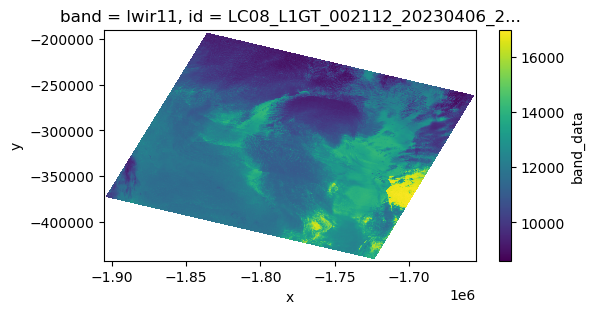

In [32]:
plt.figure(figsize=(6, 3))
ls_thermal.plot.imshow(x='x',y='y')#,vmin=0,vmax=0.0008)
# (dataOutWV_xrGPy-dataOutWV_xrK).plot.imshow(x='longitude',y='latitude',vmin=-0.00012,vmax=0.00012)

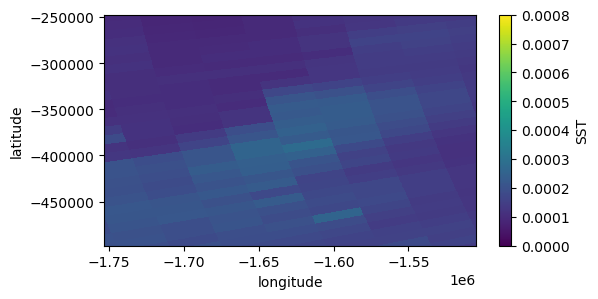

In [122]:
plt.figure(figsize=(6, 3))
dataOutWV_xr.plot.imshow(x='longitude',y='latitude',vmin=0,vmax=0.0008)
# (dataOutWV_xrGPy-dataOutWV_xrK).plot.imshow(x='longitude',y='latitude',vmin=-0.00012,vmax=0.00012)

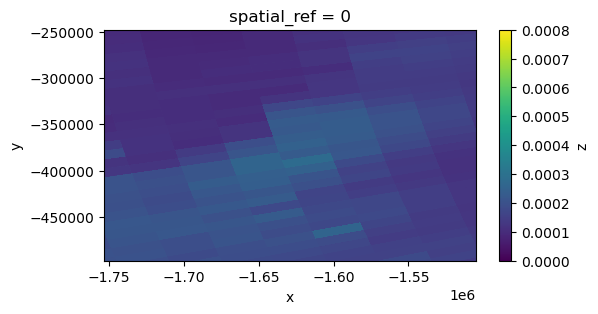

In [123]:
plt.figure(figsize=(6, 3))
WV_xr.plot.imshow(x='x',y='y',vmin=0,vmax=0.0008)

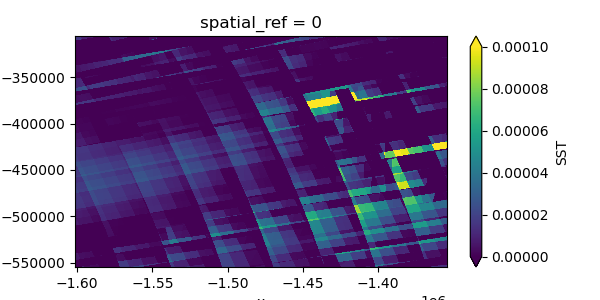

In [333]:
plt.figure(figsize=(6, 3))
(WV_xr-WV_xrK).plot.imshow(x='x',y='y',vmin=0,vmax=0.0001)

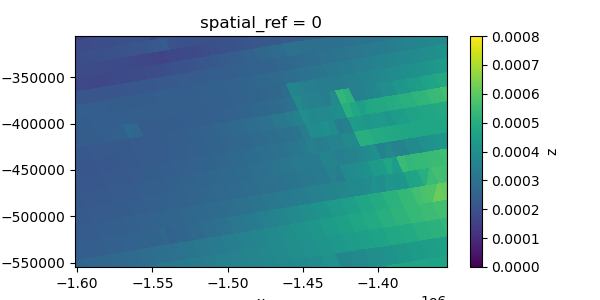

In [308]:
plt.figure(figsize=(6, 3))
WV_xrK.plot.imshow(x='x',y='y',vmin=0,vmax=0.0008)

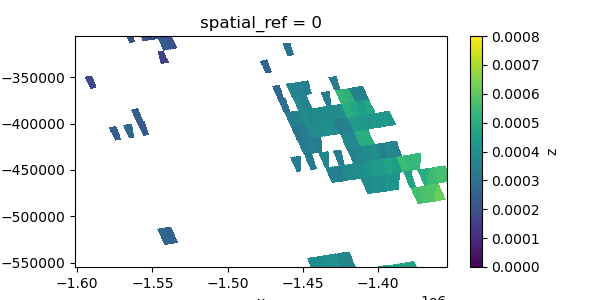

In [318]:
plt.figure(figsize=(6, 3))
WV_xr.plot.imshow(x='x',y='y',vmin=0,vmax=0.0008)

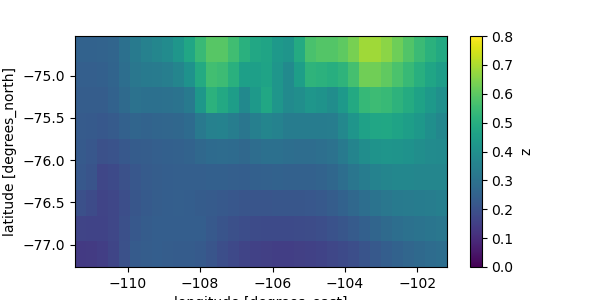

In [208]:
plt.figure(figsize=(6, 3))
dataPG_sub300.plot.imshow(x='lon',y='lat',vmin=0,vmax=0.8)

In [ ]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = mod07[WV]
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.Longitude,data0.Latitude,data0.values,vmin=0,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_ylim([-90, -55])
ax.set_xlim([-135,-62.5])
# ax.set_ylim([-75, -72])
# ax.set_xlim([-107,-100])
cbar = plt.colorbar(cb)
plt.tight_layout()

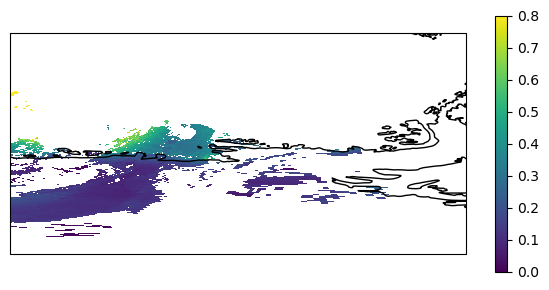

In [66]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = mod07[param]
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.Longitude,data0.Latitude,data0.values,vmin=0,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_ylim([-90, -55])
ax.set_xlim([-135,-62.5])
# ax.set_ylim([-75, -72])
# ax.set_xlim([-107,-100])
cbar = plt.colorbar(cb)
plt.tight_layout()

In [ ]:
# Plot water vapor data ***need to comment out the delete code above for this to work
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
# cb = ax.pcolormesh(lon,lat,dataK,vmin=0,vmax=0.8,transform=ccrs.PlateCarree())
# cb = ax.pcolormesh(lon,lat,data,vmin=0,vmax=0.8,transform=ccrs.PlateCarree())
# cb = ax.pcolormesh(dataPG_sub30.lon,dataPG_sub30.lat,dataPG_sub30,vmin=0,vmax=0.8,transform=ccrs.PlateCarree())
# cb = ax.pcolormesh(lon,lat,dataGPy-dataK,vmin=-0.15,vmax=0.15,transform=ccrs.PlateCarree())
# cb = ax.pcolormesh(data0.Longitude,data0.Latitude,data0.values,vmin=0,vmax=0.8,transform=ccrs.PlateCarree(),zorder=3)
cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,vmin=0,vmax=0.0008,transform=cartopy.crs.epsg(3031))
ax.coastlines()
# ax.set_ylim([-90, -55])
# ax.set_xlim([-135,-62.5])
# ax.set_ylim([-75, -72])
# ax.set_xlim([-107,-100])
# ax.set_ylim([-81, -61])
# ax.set_xlim([-135,-93])
# ax.set_ylim([-75.6, -72]) # close in on LC08_L1GT_004112_20230130_20230208_02_T2_151021_Cel
# ax.set_xlim([-107,-99])
ax.set_ylim([-77.1, -74.7]) # close in on LC08_L1GT_002114_20190206_20201016_02_T2_145810_Cel
ax.set_xlim([-107.2,-101.4])
cbar = plt.colorbar(cb)
plt.tight_layout()

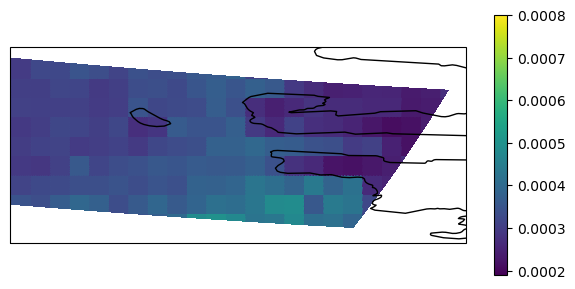

In [65]:
# Plot water vapor data ***need to comment out the delete code above for this to work
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,vmin=0.00019,vmax=0.0008,transform=cartopy.crs.epsg(3031)) #
ax.coastlines()
ax.set_ylim([-75, -72])
ax.set_xlim([-107,-100])
cbar = plt.colorbar(cb)
plt.tight_layout()

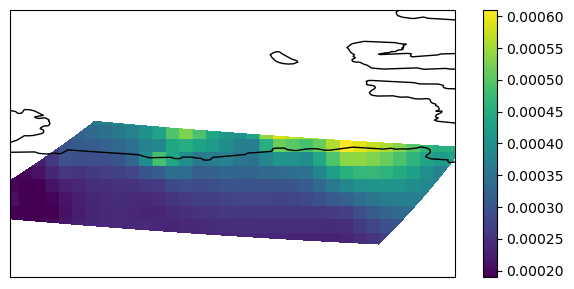

In [106]:
# For [2:3], plot water vapor data ***need to comment out the delete code above for this to work
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,vmin=0.00019,vmax=0.00061,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

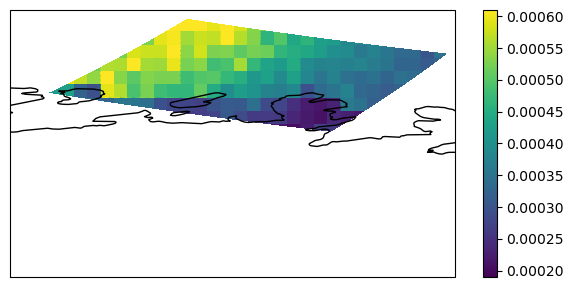

In [45]:
# For Dotson, plot water vapor data ***need to comment out the delete code above for this to work
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,vmin=0.00019,vmax=0.00061,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-121,-111])
cbar = plt.colorbar(cb)
plt.tight_layout()

### Make a list of images w SST in a desired box

In [ ]:
# # To make a list of images with SST in a desired box
# catalog = intake.open_stac_item_collection(items)

# # Include only Landsat 8 scenes
# catalog_list = [x for x in list(catalog) if x[3]=='8']

# if calib==1:
#     print('Running calibration!')
    
# mm=0
# lsat_good = []

# for img in catalog_list[847:1047]:
#     print(img)
    
#     scene = catalog[img]
#     timestr = scene.metadata['datetime'].strftime('%H%M%S')

#     if calib==1:
#         outFile = f'{lsatpath}{SSTpath}/{img}_{timestr}_Cel_calib.tif'
#     elif calib==0:
#         outFile = f'{lsatpath}{SSTpath}/{img}_{timestr}_Cel.tif'
    
#     if os.path.isfile(outFile):
#         print (f'{img} - atm corr exists')

#     else:
#         print(mm)
#         mm+=1
#         # Open all desired bands for one scene
#         ls_scene = landsat_to_xarray(scene)
#         ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

#         # Create classification mask
#         ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
        
#         try:
#             # Check for any open ocean pixels - go to next image if none - 9.3 s
#             mask = np.ones(ls_scene.shape[1:])
#             mask[ls_scene.mask!=3] = np.nan
#             ls_thermal = ls_scene.sel(band='lwir11').compute()
#             # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
#             if calib==0:
#                 ls_box = (ls_thermal*mask).sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))
#             else:
#                 ls_box = ls_thermal
                
#             if ((ls_box).notnull()).sum().values==0:
#                 print (f'{img} has no SSTs')
#                 del ls_scene, scene, mask, ls_box
#                 gc.collect()

#             else:
#                 lsat_good.append([img,((ls_box).notnull()).sum().values])
#                 del ls_scene, scene, mask, ls_box, ls_thermal

#         except Exception as e:
#             print (f'{img} has no SSTs: {e}')
        
#         gc.collect()

In [8]:
# # Save list and re-open list
# import pickle
# with open(lsatpath+'landsat8_goodfiles_dotson_2021_2023', "wb") as fp:   #Pickling
#     pickle.dump(lsat_good, fp)

# with open(lsatpath+'landsat8_goodfiles_dotson_1', "rb") as fp:   # Unpickling
#     bb = pickle.load(fp)
# len(bb)

# import csv

# with open(lsatpath+'landsat8_goodfiles_dotson_forTed.csv', 'w', newline = '') as csvfile:
#     my_writer = csv.writer(csvfile, delimiter = ' ')
#     my_writer.writerow(bb)

In [33]:
# # Plot water vapor data ***need to comment out the delete code above for this to work
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-76, -69])
# ax.set_xlim([-115,-95])
# cbar = plt.colorbar(cb)
# plt.tight_layout()

In [ ]:
# # Plot SST data ***need to comment out the delete code above for this to work
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(WV_xr.x,WV_xr.y,SST,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-74.4, -74.2])
# ax.set_xlim([-103.9,-103.5])
# cbar = plt.colorbar(cb)
# # cbar.set_clim(-1, -6) # set limits of color map
# plt.tight_layout()

### Mosaic SST images from Xarray
https://github.com/pangeo-data/cog-best-practices/issues/4

# Validate via GHRSST iQUAM data
https://www.star.nesdis.noaa.gov/socd/sst/iquam/?tab=0&dateinput_year=2023&dateinput_month=02&dayofmoninput_day=26&dateinput_hour=00&dayofmon=monthly&qcrefsst=_qcrey&qcrefsst=_qccmc&outlier=qced#qmap

In [17]:
# Landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# Paths
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'
SSTpath = lsatpath / 'SST/Validation/iQuamIntercomp/'
iQpath = lsatpath / 'iQuam'

WV = 'Water_Vapor'

# For geopandas and tile plots
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}_iQuam.geojson'

interp = 1

In [18]:
# Get iQuam file paths in directory between desired dates
start_yrmo = '202109'
end_yrmo = '202304'

yrmo = []
m0 = start_yrmo

# Make a list of months between start and end
while int(m0) <= int(end_yrmo):
    calc_dt = datetime.strptime(f'{m0[:4]}-{m0[4:]}', '%Y-%m')
    yrmo.append(calc_dt.strftime("%Y%m"))
    m0 = (calc_dt + relativedelta(months=1)).strftime("%Y%m")

# Get file names and select only those matching dates from yrmo    
iQfiles = os.listdir(iQpath)
iQfiles = [x for x in iQfiles if x[:6] in yrmo]
print (len(iQfiles))

os.chdir(iQpath)

20


In [11]:
# # Open Argos data from iQuam files
# # iquam_file = lsatpath / 'iQuam/202304-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202303-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202302-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202301-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202212-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202211-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202210-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # # iquam_file = lsatpath / 'iQuam/202209-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # # iquam_file = lsatpath / 'iQuam/202208-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # # iquam_file = lsatpath / 'iQuam/202207-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # # iquam_file = lsatpath / 'iQuam/202206-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc'
# # # iquam_file = lsatpath / 'iQuam/202205-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # # iquam_file = lsatpath / 'iQuam/202204-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc'
# # iquam_file = lsatpath / 'iQuam/202203-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202202-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc'
# # iquam_file = lsatpath / 'iQuam/202201-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# # iquam_file = lsatpath / 'iQuam/202112-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc'
# iquam_file = lsatpath / 'iQuam/202111-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc'
# # iquam_file = lsatpath / 'iQuam/202110-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv05.0.nc'
# # iquam_file = lsatpath / 'iQuam/202109-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc'

# # iquam_file = lsatpath / 'iQuam/202101-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# # iquam_file = lsatpath / 'iQuam/202001-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv10.0.nc'
# # iquam_file = lsatpath / 'iQuam/201901-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv13.0.nc'
# # iquam_file = lsatpath / 'iQuam/201801-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv10.0.nc'
# # iquam_file = lsatpath / 'iQuam/201701-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# # iquam_file = lsatpath / 'iQuam/201601-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# # iquam_file = lsatpath / 'iQuam/201501-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# # iquam_file = lsatpath / 'iQuam/201401-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'
# df = xr.open_dataset(iquam_file)
# iquam = df.to_dataframe()
# iquam.head(2)

In [40]:
# iquam_file = 'https://www.star.nesdis.noaa.gov/pub/sod/sst/iquam/v2.10/202304-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'
# df = xr.open_dataset(iquam_file,engine='netcdf4')

In [12]:
# # Subset to Antarctica
# ant = iquam[(iquam.lat<-65)&(iquam.lon>-142)&(iquam.lon<-72)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)]  # Entire West Antarctica (later)
# # ant = iquam[(iquam.lat<-69)&(iquam.lon>-125)&(iquam.lon<-98)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)] # Amundsen Sea
# print(f'{ant.shape[0]} measurements')
# ant.head(3)

In [19]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

We are already authenticated with NASA EDL


In [20]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [21]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/42921/status,
Dashboard: /user/tsnow03/proxy/42921/status,Workers: 4
Total threads: 4,Total memory: 30.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40157,Workers: 4
Dashboard: /user/tsnow03/proxy/42921/status,Total threads: 4
Started: Just now,Total memory: 30.89 GiB
Comm: tcp://127.0.0.1:43975,Total threads: 1
Dashboard: /user/tsnow03/proxy/34605/status,Memory: 7.72 GiB
Nanny: tcp://127.0.0.1:40209,


In [22]:
# Derive NLSST coefficiencts from MODTRAN files

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
atmcor = {}

for mo in months:
    print (f'Month: {mo}')
    NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
    if os.path.isfile(NLSST_input_file):
        print ('NLSST input exists')
        modtran_lut = pd.read_pickle(NLSST_input_file)
    else:
        spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
        prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
        modtran_lut = prep_NLSST(atmpath,prefix,spec_hu_file)
        modtran_lut.to_pickle(NLSST_input_file)
    
    NLSST_results = derive_NLSST(modtran_lut)
    a0 = np.around(NLSST_results.params.Intercept,2)
    a1 = np.around(NLSST_results.params.toa,2)
    a2 = np.around(NLSST_results.params.tcwv_toa,2)
        
    atmcor[mo] = {"a0": a0, "a1": a1, "a2": a2}

print(NLSST_results.summary())

Month: 01
NLSST input exists
Month: 02
NLSST input exists
Month: 03
NLSST input exists
Month: 04
NLSST input exists
Month: 05
NLSST input exists
Month: 06
NLSST input exists
Month: 07
NLSST input exists
Month: 08
NLSST input exists
Month: 09
NLSST input exists
Month: 10
NLSST input exists
Month: 11
NLSST input exists
Month: 12
NLSST input exists
                            OLS Regression Results                            
Dep. Variable:                surface   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 2.158e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:17:54   Log-Likelihood:                 1360.2
No. Observations:                1629   AIC:                            -2714.
Df Residuals:                    1626   BIC:                            -2698.
Df Model:           

In [23]:
# Set up projections
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the Landsat file

In [ ]:
# For each iquam file, pair West Antarctic Argo buoy data with Landsat data and create calibrated SSTs
valid = []

# Buffer around iquam point used to create a bounding box for Landsat sample
lon_add = 0.05
lat_add = 0.01

# Temporal search range (days) before/after iquam measurement for finding Landsat image
time_add = 0.5

for iquam_file in iQfiles:
    # Open Argos data from iQuam file
    df = xr.open_dataset(iquam_file)
    iquam = df.to_dataframe()
    
    # Subset to Antarctica
    ant = iquam[(iquam.lat<-65)&(iquam.lon>-142)&(iquam.lon<-72)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)]  # Entire West Antarctica (later)
    # ant = iquam[(iquam.lat<-69)&(iquam.lon>-125)&(iquam.lon<-98)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)] # Amundsen Sea
    print('')
    print(f'{iquam_file[:6]}: {ant.shape[0]} measurements')

    for idx in range(ant.shape[0]):

        # Create search area
        ilat = ant['lat'].iloc[idx]
        ilon = ant['lon'].iloc[idx]
        bboxV = (ilon-lon_add,ilat-lat_add,ilon+lon_add,ilat+lat_add)

        # Create Landsat temporal search range in correct format
        ihr = int(ant.hour.iloc[idx])
        iyr = int(ant.year.iloc[idx])
        imo = int(ant.month.iloc[idx])

        calc_dt = datetime.strptime(f'{iyr}-{imo}-{int(ant.day.iloc[idx])} {ihr}', '%Y-%m-%d %H')
        start_dt = (calc_dt + timedelta(days=-time_add))
        end_dt = (calc_dt + timedelta(days=time_add))

        timeRangeV = f'{start_dt}/{end_dt}'

        # Search for desired Landsat scenes
        items = search_stac(url,bboxV,timeRangeV,collection,gjson_outfile)

        # Load the geojson file and open stac catalog
        catalog = intake.open_stac_item_collection(items)
        gf = gpd.read_file(gjson_outfile)

        # Exclude Landsat 9
        catalog_list = [x for x in items if x.id[3]=='8']
        num_scene = len(catalog_list)
        print(f'{num_scene} Landsat 8 items')

        # If any matching landsat scenes are found create calibrated SSTs for them
        if num_scene>0:

            # Reproject to determine bounding box in espg 3031
            # polarx,polary = topolar.transform([bboxV[3],bboxV[1]],[bboxV[0],bboxV[2]])
            sbox,checkbox = lsat_reproj(source_crs,target_crs,(bboxV[0],bboxV[1],bboxV[2],bboxV[3]))

            # Create polygon for later cropping
            polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])
            
            # Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
            minx, miny, maxx, maxy = polygon.bounds
            polarx = [minx, maxx]
            polary = [miny, maxy]

            # Create calibrated SSTs for each matching landsat scene
            for sceneid in catalog_list:
                print(sceneid.id)

                scene = catalog[sceneid.id]
                timestr = scene.metadata['datetime'].strftime('%H%M%S')

                outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'

                if os.path.isfile(outFile):
                    print (f'{sceneid.id} - atm corr exists')
                    ls_scene = xr.open_dataset(outFile,chunks=dict(x=512, y=512),engine='rasterio')

                    # Subset all scenes and check for right dimensions because y order changes sometimes
                    ls_sub = subset_img(ls_scene['band_data'].sel(band=1),polarx,polary) # subset so easier to work with 
                    ls_sub = crop_xarray_dataarray_with_polygon(ls_sub, polygon) # crop data to exact bounding box

                    # Calibrate using MODIS
                    ls_sub = ls_sub * calib_m + calib_b

                    # Remove all pixels that are too cold
                    ls_sub = ls_sub.where(ls_sub>=-1.9,np.nan)

                    lsat = np.nanmean(ls_sub)
                    lstd = np.nanstd(ls_sub)

                else:
                    # Open all desired bands for one scene
                    ls_scene = landsat_to_xarray(sceneid)
                    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

                    # Create classification mask
                    ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)

                    try:
                        # Check for any open ocean pixels - go to next image if none - ??? s
                        mask = np.ones(ls_scene.shape[1:])
                        mask[ls_scene.mask!=3] = np.nan
                        ls_thermal = ls_scene.sel(band='lwir11').compute()

                        # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
                        ls_box = subset_img(ls_thermal*mask,polarx,polary)

                        if ((ls_box).notnull()).sum().values==0:
                            print (f'{sceneid.id} has no SSTs')
                            try:
                                del ls_scene, scene, mask, ls_thermal, ls_box
                            except:
                                pass
                            gc.collect()
                            continue

                        # Use band ratios for RF cloud pixel classification
                        ####

                        # Atmospheric correction using MODIS
                        # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
                        mod07,modfilenm = open_MODIS(ls_scene,scene,modout_path)

                        # Create water vapor files aligned and subsampled to Landsat
                        spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
                        WV_xr = get_wv2(ls_scene,mod07,spacing,WV,scene,interp=interp)

                        # Create SST by masking and using water vapor to apply atmospheric correction
                        SST = apply_NLSST(ls_thermal,scene,mask,WV_xr,atmcor)

                        # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
                        # data variables in COG (click on white paper info button in xarray readout)
                        SST.attrs['MODIS_WV'] = modfilenm

                        # Save to a cloud-optimized Geotiff
                        SST.rio.to_raster(raster_path=outFile, driver="COG")

                        # Calibrate using MODIS
                        SST = SST * calib_m + calib_b

                        print (f'Mean SST: {np.nanmean(SST)}')

                        # Subset all scenes and check for right dimensions because y order changes sometimes
                        ls_sub = subset_img(SST,polarx,polary) # subset so easier to work with 
                        ls_sub = crop_xarray_dataarray_with_polygon(ls_sub, polygon) # crop data to exact bounding box

                        # Remove all pixels that are too cold
                        ls_sub = ls_sub.where(ls_sub>-1.9,np.nan)

                        lsat = np.nanmean(ls_sub)
                        lstd = np.nanstd(ls_sub)

                        try:
                            del mask, ls_thermal, mod07, WV_xr, SST
                        except:
                            pass

                    except Exception as e:
                        print (sceneid.id, e)
                        lsat = np.nan
                        lstd = np.nan

                # Record coincident data from landsat and argo float
                argo = ant.sst.iloc[idx]-273.15
                valid.append([sceneid.id,lsat,lstd, ant.iloc[idx].name,argo])
                print (f'Argo temp: {argo}, Landsat 8 mean: {lsat}+-{lstd}')

                try:
                    del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST
                except:
                    pass

                gc.collect()


202111: 28 measurements
0 Landsat 8/9 items
0 Landsat 8 items
0 Landsat 8/9 items
0 Landsat 8 items
0 Landsat 8/9 items
0 Landsat 8 items
0 Landsat 8/9 items
0 Landsat 8 items
1 Landsat 8/9 items
0 Landsat 8 items
1 Landsat 8/9 items
0 Landsat 8 items
0 Landsat 8/9 items
0 Landsat 8 items
2 Landsat 8/9 items
1 Landsat 8 items
lsat_reproj normal orientation
bbox=[(-1209448.2025145527, -1443921.3636712483), (-1208022.2022886053, -1442218.907802064), (-1210537.5079356632, -1440108.3157613198), (-1211966.4773342088, -1441808.2801988719)]
lbox=(-140.05, -72.81000305175782, -139.95, -72.79000305175781)
checkbox=[-140.05        -72.81000305 -139.95        -72.79000305]
LC08_L1GT_027112_20211109_20211117_02_T2


In [ ]:
# Put data into DataFrame and save    
headers = ['L8_filename','L8_SST','L8_std','Argo_id','Argo_SST']
lsat_mod_df = pd.DataFrame(valid,columns=headers)
out_df = lsatpath / f'Landsat_validation_20240305_{start_yrmo}_{end_yrmo}'
lsat_mod_df.to_pickle(out_df)

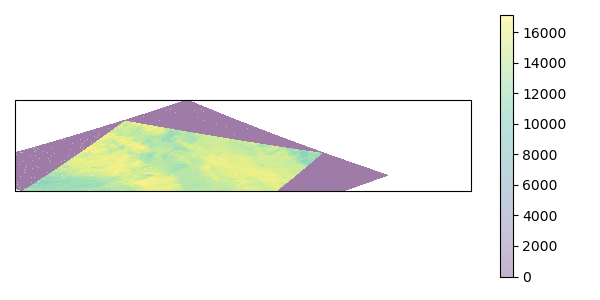

In [31]:
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.pcolormesh(mod07.Longitude,mod07.Latitude,mod07.Water_Vapor,transform=ccrs.PlateCarree())
# cb = ax.pcolormesh(ls_scene.x,ls_scene.y,ls_scene.sel(band='lwir11'),alpha=0.3,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-70, -68])
# ax.set_xlim([-142,-132])
# plt.colorbar(cb)
# plt.tight_layout()

In [55]:
Lfile = '/home/jovyan/Landsat_SST_algorithm/Data/SST/Validation/LC08_L1GT_228108_20200123_20201016_02_T2_141253_Cel_calib.tif'
ls_scene = xr.open_dataset(Lfile)
ls_scene

<xarray.Dataset>
Dimensions:      (band: 1, x: 9081, y: 9101)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.495e+06 -2.495e+06 ... -2.223e+06 -2.223e+06
  * y            (y) float64 5.046e+05 5.046e+05 ... 2.316e+05 2.316e+05
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

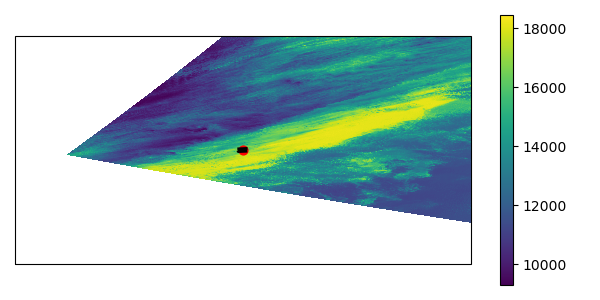

In [18]:
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_ylim([ilat-1,ilat+1])
ax.set_xlim([ilon-2,ilon+2])
cb = ax.pcolormesh(ls_scene.x,ls_scene.y,ls_scene.sel(band=1).to_array().isel(variable=0),transform=cartopy.crs.epsg(3031))
plt.scatter([ilon],[ilat],c='r',s=40,transform=ccrs.PlateCarree())
plt.plot([polarx[0],polarx[0],polarx[1],polarx[1],polarx[0]],[polary[0],polary[1],polary[1],polary[0],polary[0]],lw=2,ls='--',color='k',transform=cartopy.crs.epsg(3031))
ax.coastlines()
plt.colorbar(cb)
plt.tight_layout()

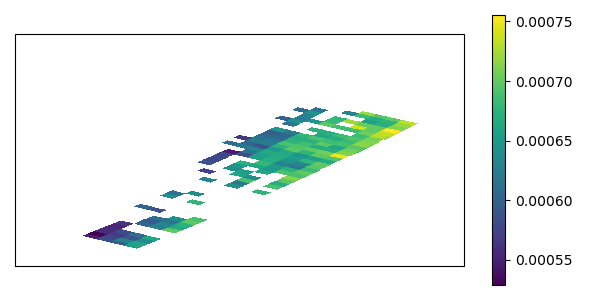

In [222]:
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-72.6, -69.5])
# ax.set_xlim([-129,-123])
# plt.colorbar(cb)
# plt.tight_layout()

In [159]:
# Plot tiles of all scenes found
plot_search(gf,satellite,colnm)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

## Process calibrated Landsat scenes to create matchups

In [20]:
# Read in processed matchups
# out_df = lsatpath / 'Landsat_validation_20230822_2023_01'
# df1 = pd.read_pickle(out_df)
# out_df = lsatpath / 'Landsat_validation_20230822_2022_01'
# df2 = pd.read_pickle(out_df)
# out_df = lsatpath / 'Landsat_validation_20230822_2021_01'
# df3 = pd.read_pickle(out_df)
# out_df = lsatpath / 'Landsat_validation_20230822_2018_01'
# df4 = pd.read_pickle(out_df)
# valids = pd.concat([df1,df2,df3,df4])

out_df = lsatpath / f'Landsat_validation_20231114_{start_yrmo}_{end_yrmo}'
df1 = pd.read_pickle(out_df)

valids = df1
valids

,L8_filename,L8_SST,L8_std,Argo_id,Argo_SST
0,LC08_L1GT_009110_20230117_20230131_02_T2,-0.993101,0.199321,2547953,-0.879
1,LC08_L1GT_009109_20230117_20230131_02_T2,NaN,NaN,2547953,-0.879
2,LC08_L1GT_026112_20220310_20220321_02_T2,-0.471986,0.061082,2110117,-1.424
3,LC08_L1GT_026112_20211220_20211229_02_T2,NaN,NaN,2271093,-1.694
4,LC08_L1GT_029112_20211022_20211103_02_T2,NaN,NaN,2542149,-1.822
5,LC08_L1GT_029111_20211022_20211103_02_T2,NaN,NaN,2542149,-1.822
6,LC08_L1GT_227108_20220105_20220114_02_T2,-1.792125,0.084265,2236842,0.544
7,LC08_L1GT_027112_20220128_20220204_02_T2,-1.773932,0.088081,2237070,-1.589
8,LC08_L1GT_008109_20220107_20220114_02_T2,0.618711,0.157383,2237071,-0.173


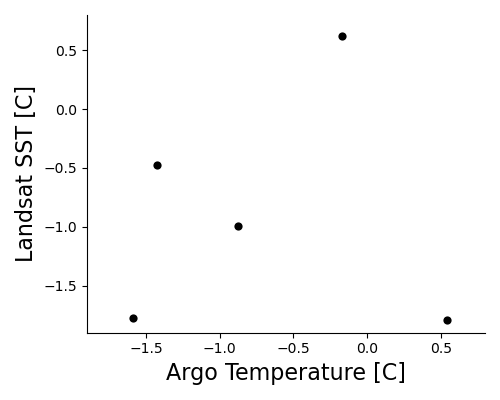

In [29]:
# Plot data points and RANSAC regression
fig, ax = plt.subplots(figsize=(5, 4))
xi = np.arange(-7.0,5.0,1.0)

data = valids

ax.tick_params(labelsize=10)
ax.scatter(data['Argo_SST'],data['L8_SST'],color='k',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.scatter(xC,yLC,color='r',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*resultC.params.L8_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
# a1.text(-2.1,-2.85,f'y={np.around(resultC.params.L8_SST,2)}x+{np.around(resultC.params.Intercept,2)}   p={p_val}',fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-1.9,0.8])
ax.set_xlim([-1.9,0.8])
ax.set_xlabel('Argo Temperature [C]',fontsize=16)
ax.set_ylabel('Landsat SST [C]',fontsize=16)
# a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()